# Import Modules

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.util import montage
from skimage.transform import rotate
import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import keras.backend as K
import nibabel as nib
import nilearn as nl
import nilearn.plotting as nlplt
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
import plotly.express as px

# Exploratory Data Analysis

In [2]:
# Define the file path for the scanner data
scanner_data = pd.read_csv('/Users/eridon/Desktop/LongitudinalMultipleSclerosisLesionSegmentationChallengeMiccai21/scanners.csv')

# Read the CSV file into a DataFrame
scanner_data

patient    time      device_manufacturer   device_model  \
0         78  time01       GE MEDICAL SYSTEMS  Optima MR450w   
1         78  time02       GE MEDICAL SYSTEMS  Optima MR450w   
2         69  time01  Philips Medical Systems        Achieva   
3         69  time02  Philips Medical Systems        Achieva   
4         20  time01                  Philips        Achieva   
..       ...     ...                      ...            ...   
195       73  time02       GE MEDICAL SYSTEMS     Signa HDxt   
196       96  time01                  SIEMENS         prisma   
197       96  time02                  SIEMENS         prisma   
198        6  time01                  SIEMENS         Avanto   
199        6  time02                  SIEMENS         Avanto   

     device_field_strength  
0                      1.5  
1                      1.5  
2                      1.5  
3                      1.5  
4                      1.5  
..                     ...  
195                    1.5  
196                    3.0  
197                    3.0  
198                    1.5  
199                    1.5  

[200 rows x 5 columns]

In [3]:
# Display the column names
scanner_data.columns

Index(['patient', 'time', 'device_manufacturer', 'device_model',
       'device_field_strength'],
      dtype='object')

In [4]:
# Display the shape
scanner_data.shape

(200, 5)

In [5]:
# Display the datatypes
scanner_data.dtypes

patient                    int64
time                      object
device_manufacturer       object
device_model              object
device_field_strength    float64
dtype: object

In [6]:
# Display info about the dataset
scanner_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient                200 non-null    int64  
 1   time                   200 non-null    object 
 2   device_manufacturer    200 non-null    object 
 3   device_model           200 non-null    object 
 4   device_field_strength  200 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 7.9+ KB


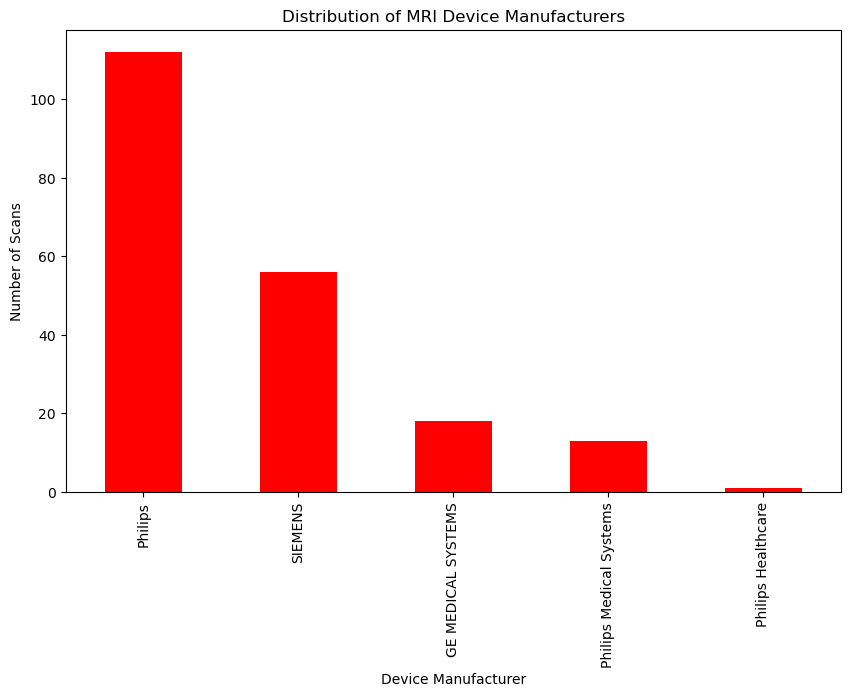

In [7]:
# Count the occurrences of each device manufacturer
manufacturer_count = scanner_data['device_manufacturer'].value_counts()

# Plot a bar plot of device manufacturers
manufacturer_count.plot(kind='bar', color='red', figsize=(10, 6))

# Add titles
plt.title('Distribution of MRI Device Manufacturers')
plt.xlabel('Device Manufacturer')
plt.ylabel('Number of Scans')

# Display the plot
plt.show()

In [8]:
# Philips is the most common MRI manufacturer by far.

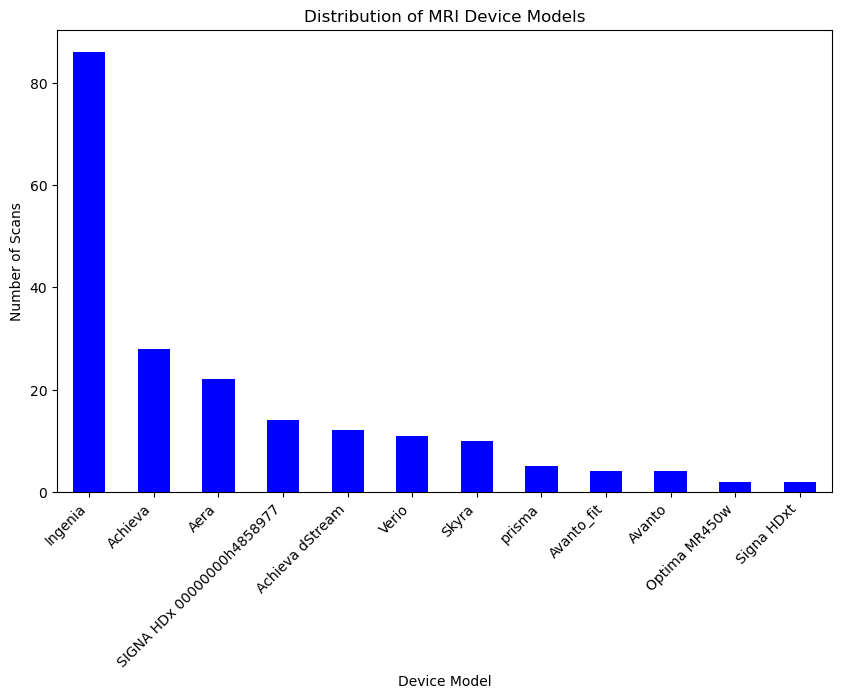

In [9]:
# Count the occurrences of each device model
model_count = scanner_data['device_model'].value_counts()

# Plot a bar plot of device models
model_count.plot(kind='bar', color='Blue', figsize=(10, 6))

# Add titles
plt.title('Distribution of MRI Device Models')
plt.xlabel('Device Model')
plt.ylabel('Number of Scans')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

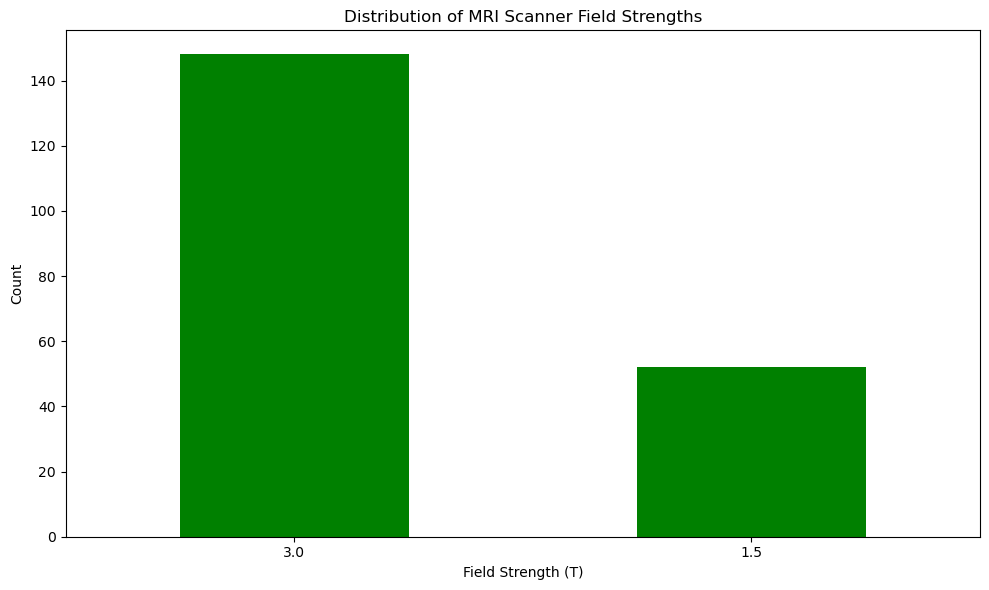

In [10]:
# Count the occurrences of each field strength
field_strength_count = scanner_data['device_field_strength'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
field_strength_count.plot(kind='bar', color='green')
plt.title('Distribution of MRI Scanner Field Strengths')
plt.xlabel('Field Strength (T)')
plt.ylabel('Count')
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()

In [11]:
# The majority of the scans were undertaken with a field strength of 3.0 (T) which suggests that the images will
# have a superior image resolution. This means that higher quality training data is fed to the model.

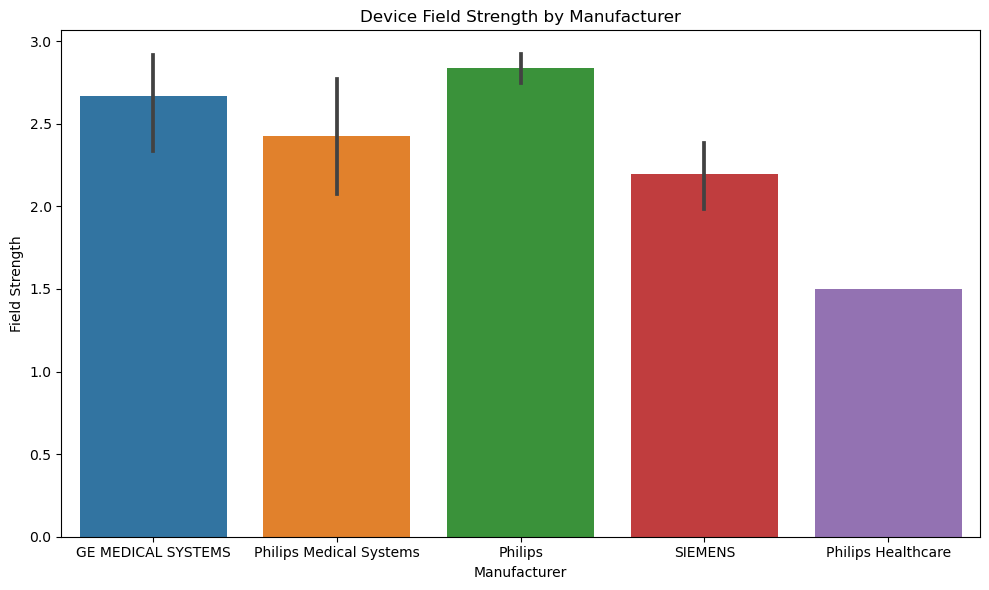

In [12]:
# Display the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=scanner_data, x='device_manufacturer', y='device_field_strength')
plt.title('Device Field Strength by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Field Strength')
plt.tight_layout()
plt.show()

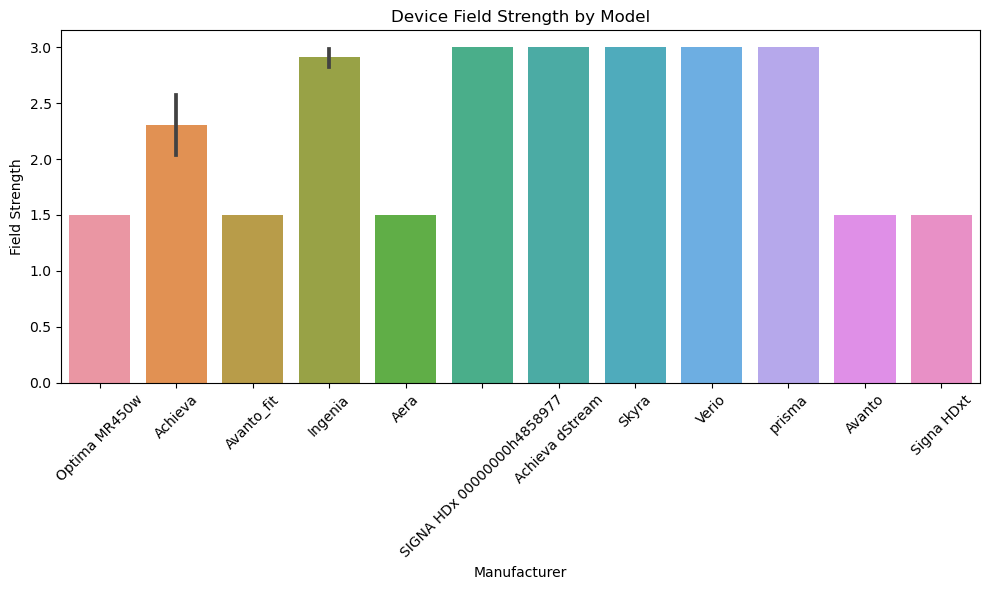

In [13]:
# Display the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=scanner_data, x='device_model', y='device_field_strength')
plt.title('Device Field Strength by Model')
plt.xlabel('Manufacturer')
plt.ylabel('Field Strength')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

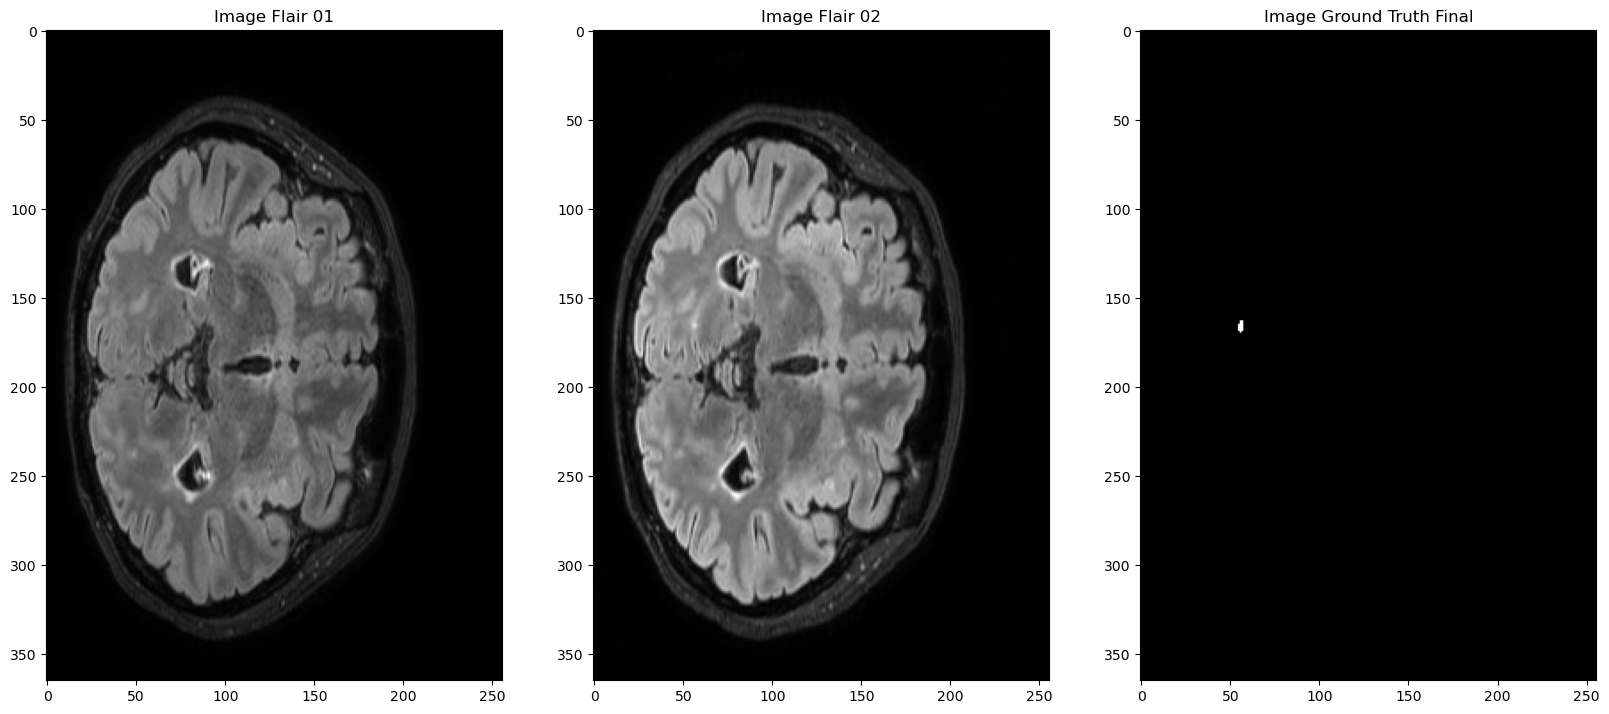

In [14]:
# Define the dataset path
train_dataset_path = '/Users/eridon/Desktop/LongitudinalMultipleSclerosisLesionSegmentationChallengeMiccai21/training'

# Load MRI images
def load_nifti_image(file_path):
    return nib.load(file_path).get_fdata()

# Load individual images
test_image_flair_01 = load_nifti_image(os.path.join(train_dataset_path, '013', 'flair_time01_on_middle_space.nii'))
test_image_flair_02 = load_nifti_image(os.path.join(train_dataset_path, '013', 'flair_time02_on_middle_space.nii'))
test_image_ground_truth_final = load_nifti_image(os.path.join(train_dataset_path, '013', 'ground_truth.nii'))

# Visualise the images
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

images = [test_image_flair_01, test_image_flair_02, test_image_ground_truth_final]

# Add titles
titles = ['Image Flair 01', 'Image Flair 02', 'Image Ground Truth Final']

# Display each image with the specified mask slice
for i, ax in enumerate(axs):
    ax.imshow(images[i][:, :, 122], cmap='gray')
    ax.set_title(titles[i])

plt.show()

In [15]:
# Print the shape of each of the above images
for i, image in enumerate(images):
    print(f"test_image_{i}.shape: {image.shape}")

test_image_0.shape: (365, 256, 256)
test_image_1.shape: (365, 256, 256)
test_image_2.shape: (365, 256, 256)


In [16]:
# From the above code we can confidently say that the images are in a 3-dimensional format.

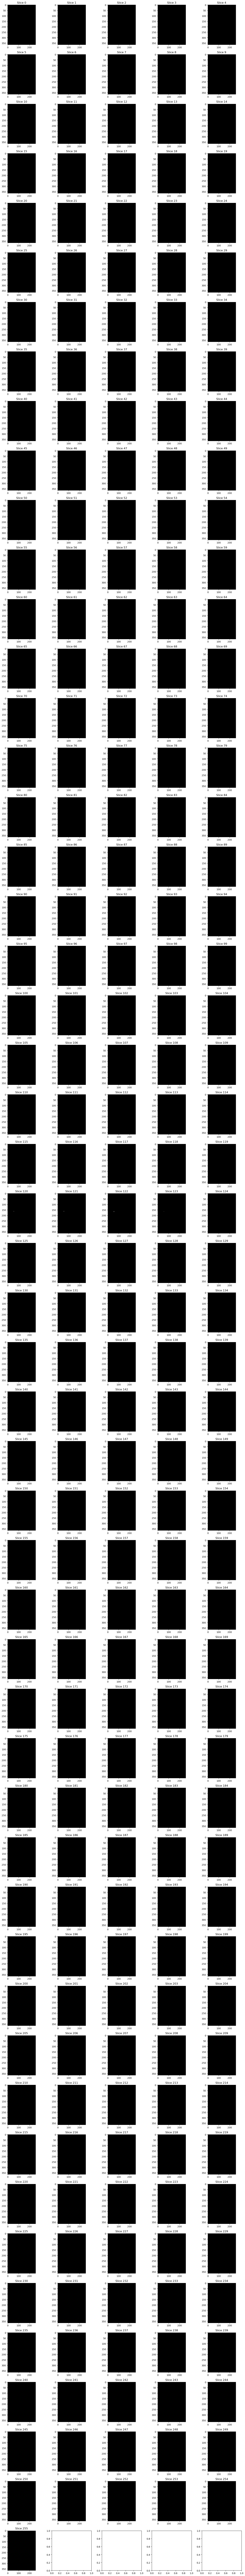

In [17]:
# Calculate the number of slices
num_slices = test_image_ground_truth_final.shape[2]

# Calculate the number of rows and columns for subplots
num_rows = (num_slices // 5) + 1
num_cols = min(num_slices, 5)

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))

# Iterate through all slices in the third dimension
for slice_index in range(num_slices):
    row_index = slice_index // num_cols
    col_index = slice_index % num_cols
    
    # Extract the slice
    slice_image = test_image_ground_truth_final[:, :, slice_index]
    
    # Display the slice
    axs[row_index, col_index].imshow(slice_image, cmap='gray')
    axs[row_index, col_index].set_title(f"Slice {slice_index}")

plt.tight_layout()
plt.show()

In [18]:
# Based on the above analysis we can determine that patient 013 exbits MS lesions shown in slices 120-123

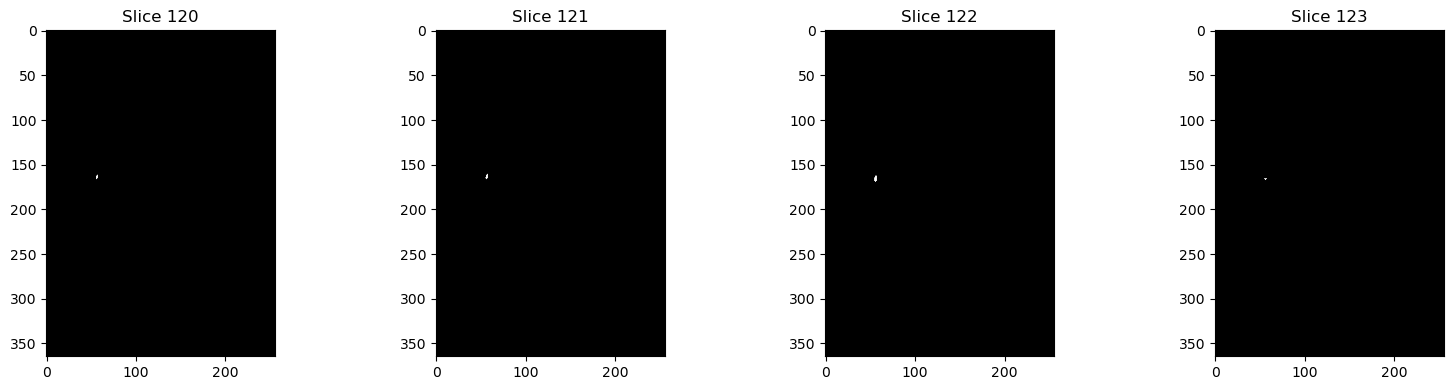

In [19]:
# Define the slice range
slice_range = range(120, 124)

# Set up subplots
plt.figure(figsize=(16, 4))

# Iterate through the specified slices
for i, slice_index in enumerate(slice_range, 1):
    plt.subplot(1, len(slice_range), i)
    slice_image = test_image_ground_truth_final[:, :, slice_index]
    
    # Display the slice
    plt.imshow(slice_image, cmap='gray')
    plt.title(f"Slice {slice_index}")

plt.tight_layout()
plt.show()

Total non-zero voxel count for brain volume: 4,915,262


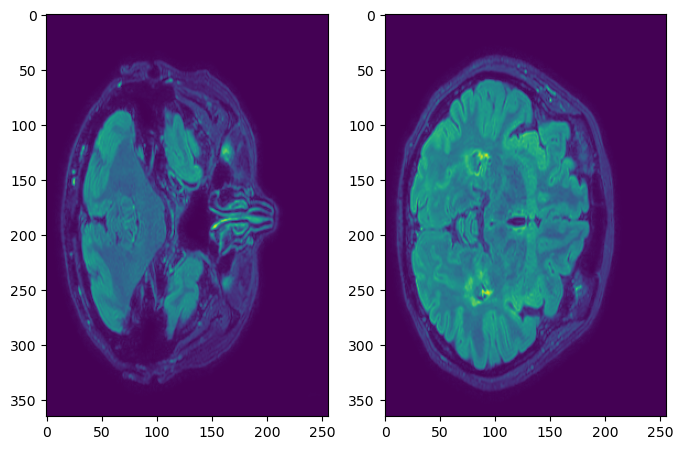

In [20]:
# Constants
VOLUME_START_AT = 90
VOLUME_SLICES = 90

# Calculate the total non-zero voxel count for the brain volume
def calculate_brain_volume(image_volume, start_slice, num_slices):
    total_count = 0
    for i in range(start_slice, start_slice + num_slices):
        slice_data = image_volume[:,:,i]
        non_zero_count = np.count_nonzero(slice_data)
        total_count += non_zero_count
    return total_count

# Example usage
example_volume = nib.load(train_dataset_path + '/013/flair_time01_on_middle_space.nii').get_fdata()

# Plot example slices
fig, axarr = plt.subplots(1, 2, figsize=(8, 10))
axarr[0].imshow(example_volume[:,:,VOLUME_SLICES])
axarr[1].imshow(example_volume[:,:,VOLUME_SLICES + 30])

# Calculate brain size for the volume
total_count = calculate_brain_volume(example_volume, VOLUME_START_AT, VOLUME_SLICES)
print(f'Total non-zero voxel count for brain volume: {total_count:,}')

In [21]:
# The above code allows us to quantify the amount of brain tissue that is present in the MRI scan. The MSSEG-2
# dataset presents a strong imbalance of postive (lesion) to negative (non-lesion) voxels (0.005%).

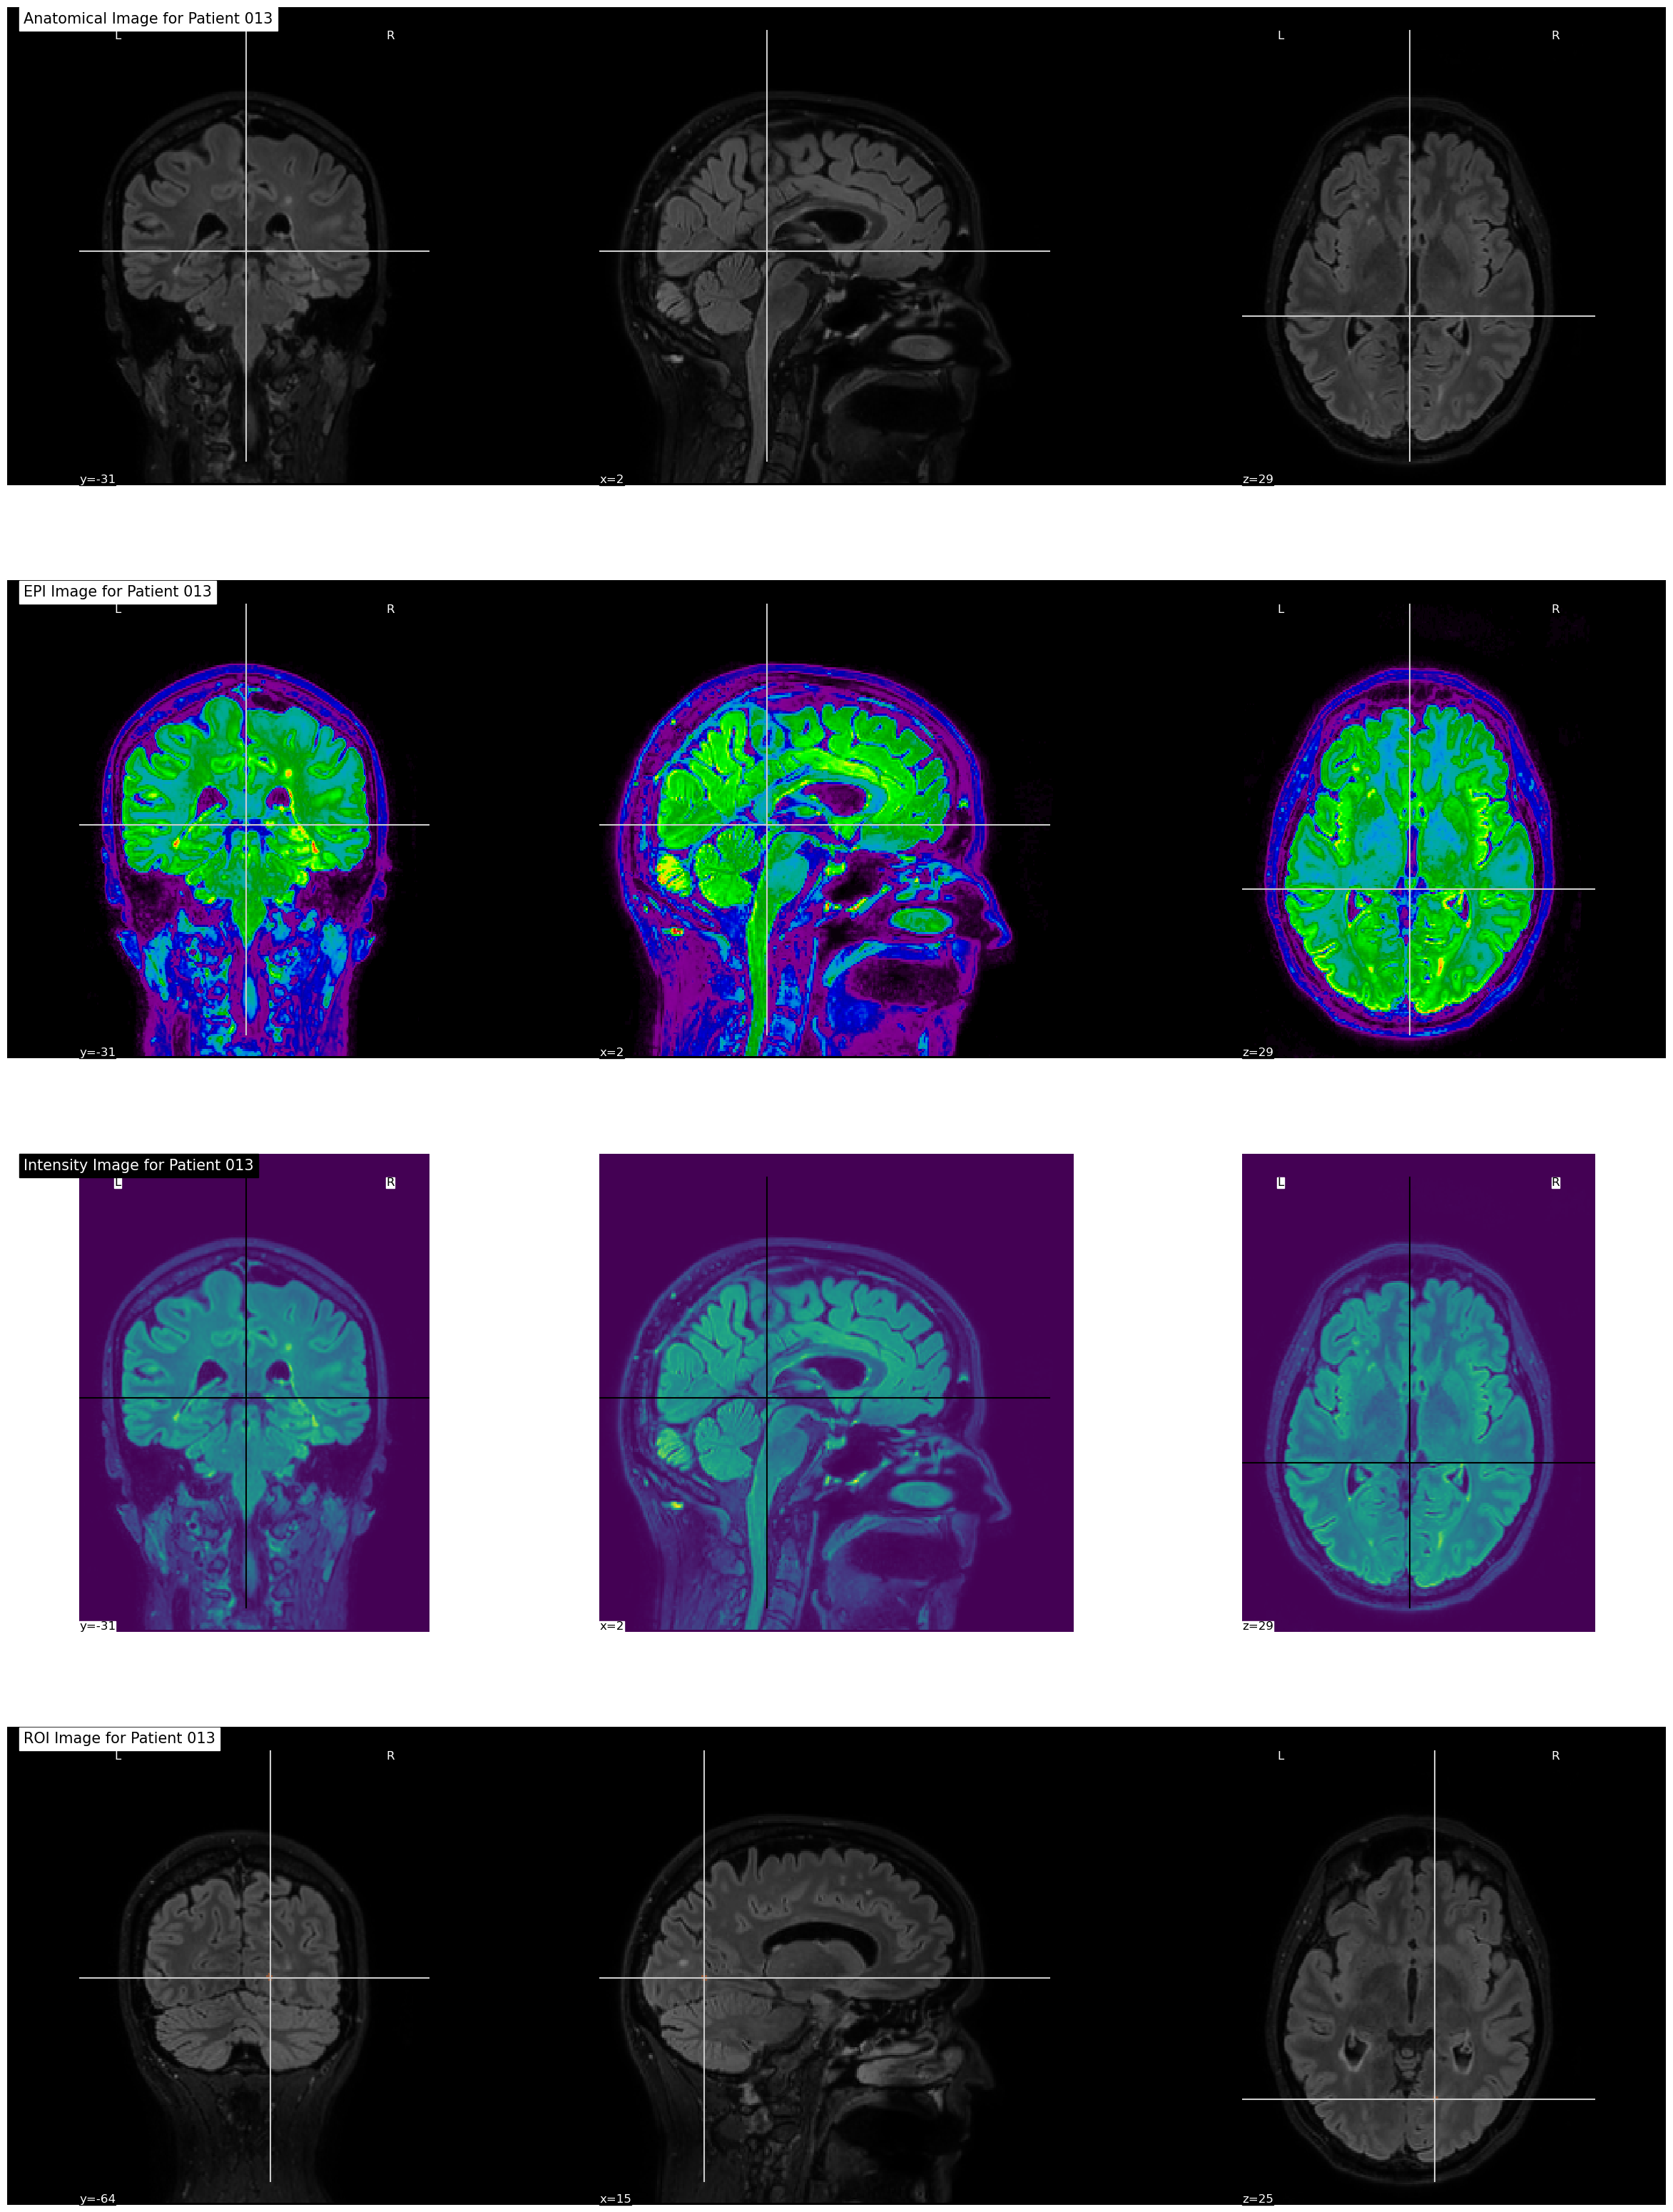

In [22]:
# Define the patient number as a constant
PATIENT_NUMBER = '013'

# Load the images
flair_image = nib.load(train_dataset_path + f'/{PATIENT_NUMBER}/flair_time02_on_middle_space.nii')
mask = nib.load(train_dataset_path + f'/{PATIENT_NUMBER}/ground_truth.nii')

# Create subplots
fig, axes = plt.subplots(nrows=4, figsize=(30, 40))

# Plot anatomical image
nlplt.plot_anat(flair_image,
                title=f'Anatomical Image for Patient {PATIENT_NUMBER}',
                axes=axes[0])

# Plot EPI image
nlplt.plot_epi(flair_image,
               title=f'EPI Image for Patient {PATIENT_NUMBER}',
               axes=axes[1])

# Plot intensity image
nlplt.plot_img(flair_image,
               title=f'Intensity Image for Patient {PATIENT_NUMBER}',
               axes=axes[2])

# Plot Region of Interest (ROI) image
nlplt.plot_roi(mask, 
               title=f'ROI Image for Patient {PATIENT_NUMBER}',
               bg_img=flair_image, 
               axes=axes[3], cmap='Paired')

# Show the entire plot
plt.show()

In [23]:
# From the above figures, we can pinpoint where the mask is present from different angles for Patient 13.

In [24]:
# # Output an animated plot of the flair image
# fig = px.imshow(flair_image.get_fdata(), animation_frame=0, title='3D Visualisation of Flair Image')
# fig.show()

In [25]:
# # Output an animated plot of the mask image
# fig = px.imshow(mask.get_fdata(), animation_frame=0, title='3D Visualisation of Mask Image')
# fig.show()

In [26]:
# Both animations allow us to approximate the best slice ranges to use for training the model.

## Define Error Metrics

In [27]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    intersection = 0
    union = 0
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection += K.sum(y_true_f * y_pred_f)
        union += K.sum(y_true_f) + K.sum(y_pred_f)
    loss = ((2. * intersection + smooth) / (union + smooth))
    return loss

def dice_coef_MS(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Split the Data

In [28]:
from sklearn.model_selection import train_test_split
import os

# Extract a list of directories
train_and_val_directories = [f.path for f in os.scandir(train_dataset_path) if f.is_dir()]

# Identify patients with lesions
patients_with_lesions = []
for directory in train_and_val_directories:
    ground_truth_path = os.path.join(directory, 'ground_truth.nii')
    ground_truth_data = load_nifti_image(ground_truth_path)
    if np.any(ground_truth_data):
        patients_with_lesions.append(directory)

# Extract IDs (patients) from directory path
def pathListIntoIds(dirList):
    x = []
    # Loop through the directory list
    for directory in dirList:
        x.append(directory[directory.rfind('/')+1:])
    return x

# Convert the list of paths into a list of IDs
train_and_test_ids = pathListIntoIds(patients_with_lesions)

# Split the IDs of patients with lesions into train and test sets in a 70:30 ratio
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.3, random_state=42)

# Further split the IDs into train and test sets in a 85:15 ratio
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15, random_state=42)

# Data Preprocessing

In [29]:
# Define the image size for resizing
IMG_SIZE=128

In [30]:
from keras.preprocessing.image import ImageDataGenerator

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,  
            height_shift_range=0.1,  
            shear_range=0.1, 
            zoom_range=0.1,  
            horizontal_flip=True,  
            vertical_flip=True,  
            fill_mode='nearest' 
        )

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        batch_ids = [self.list_IDs[k] for k in indexes]

        X, Y = self.__data_generation(batch_ids)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        'Generates data containing batch_size samples'
        X = np.zeros((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
        Y = np.zeros((self.batch_size, self.dim[0], self.dim[1], 2))

        for i, patient_id in enumerate(batch_ids):
            # Construct paths to data
            flair_path = os.path.join(train_dataset_path, patient_id, 'flair_time01_on_middle_space.nii')
            mask_path = os.path.join(train_dataset_path, patient_id, 'ground_truth.nii')

            flair_data = nib.load(flair_path).get_fdata()
            mask_data = nib.load(mask_path).get_fdata()

            # Normalise flair data
            flair_mean = np.mean(flair_data)
            flair_std = np.std(flair_data)
            flair_data_normalized = (flair_data - flair_mean) / flair_std

            mask_slice_indices = np.any(mask_data, axis=(0, 1))

            for slice_index, has_mask in enumerate(mask_slice_indices):
                if has_mask:
                    resized_flair = cv2.resize(flair_data_normalized[:, :, slice_index], (self.dim[0], self.dim[1]))
                    resized_mask = cv2.resize(mask_data[:, :, slice_index], (self.dim[0], self.dim[1]))

                    X[i, :, :, 0] = resized_flair
                    Y[i, :, :, 0] = resized_mask

        return X, Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [31]:
# from keras.models import Sequential, Model
# from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Activation
# from keras.optimizers import Adam

# def build_generator(latent_dim, input_shape):
#     model = Sequential()
#     model.add(Dense(128 * (input_shape[0] // 8) * (input_shape[1] // 8), input_dim=latent_dim))
#     model.add(Reshape((input_shape[0] // 8, input_shape[1] // 8, 128)))
#     model.add(BatchNormalization())
#     model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
#     model.add(Activation('relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
#     model.add(Activation('relu'))
#     model.add(BatchNormalization())
#     model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
#     model.add(Activation('relu'))
#     model.add(Conv2D(input_shape[2], (3, 3), activation='tanh', padding='same'))
#     return model

# def build_discriminator(input_shape):
#     input_layer = Input(shape=input_shape)
#     x = Conv2D(64, (3,3), strides=(2, 2), padding='same')(input_layer)
#     x = LeakyReLU(alpha=0.2)(x)
#     x =Dropout(0.3)(x)
#     x = Conv2D(128, (3,3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU(alpha=0.2)(x)
#     x = Dropout(0.3)(x)
#     x = Flatten()(x)
#     output_layer = Dense(1, activation='sigmoid')(x)
#     discriminator = Model(inputs=input_layer, outputs=output_layer)
#     return discriminator

# # Define input shape for GAN
# input_shape = (128, 128, 2)  

# # Create the Generator and Discriminator
# latent_dim = 100
# generator = build_generator(latent_dim, input_shape)
# discriminator = build_discriminator(input_shape)
# discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001, beta_1=0.5), metrics=['accuracy'])

# # Combine Generator and Discriminator into GAN
# discriminator.trainable = False
# gan_input = Input(shape=(latent_dim,))
# fake_image = generator(gan_input)
# gan_output = discriminator(fake_image)
# gan = Model(gan_input, gan_output)
# gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001, beta_1=0.5))

# # Define the number of steps per epoch
# steps_per_epoch = len(training_generator)

# epochs = 100
# batch_size = 1

# for epoch in range(epochs):
#     print(f"Epoch {epoch+1}/{epochs}")
#     for step in range(steps_per_epoch):
#         # Get a batch of real images
#         real_images, real_masks = training_generator[step]
        
#         # Visualize X (flair images)
#         plt.figure(figsize=(15, 5))
#         for i in range(batch_size):
#             plt.subplot(2, batch_size, i+1)
#             plt.imshow(real_images[i, :, :, 0], cmap='gray')
#             plt.title(f'Flair Image {i+1}')
#             plt.axis('off')
        
#         # Visualize Y (ground truth masks)
#         for i in range(batch_size):
#             plt.subplot(2, batch_size, i+batch_size+1)
#             plt.imshow(real_masks[i, :, :, 0], cmap='gray')
#             plt.title(f'Ground Truth Mask {i+1}')
#             plt.axis('off')
        
#         plt.tight_layout()
#         plt.show()
        
#         # Generate fake images
#         noise = np.random.normal(0, 1, (batch_size, latent_dim))
#         generated_images = generator.predict(noise)
        
#         # Visualize generated images
#         plt.figure(figsize=(15, 5))
#         for i in range(batch_size):
#             plt.subplot(2, batch_size, i+1)
#             plt.imshow(generated_images[i, :, :, 0], cmap='gray')
#             plt.title(f'Generated Image {i+1}')
#             plt.axis('off')
            
#         plt.tight_layout()
#         plt.show()
        
#         # Train the discriminator
#         combined_images = np.concatenate([real_images, generated_images])
#         labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
#         labels += 0.05 * np.random.random(labels.shape)
#         d_loss = discriminator.train_on_batch(combined_images, labels)
        
#         # Train the generator
#         noise = np.random.normal(0, 1, (batch_size, latent_dim))
#         misleading_targets = np.zeros((batch_size, 1))
#         g_loss = gan.train_on_batch(noise, misleading_targets)
        
#         # Print progress
#         print(f"Step {step}/{steps_per_epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")

In [32]:
# from medigan import Generators

# Generators().generate(
#     model_id="00007_INPAINT_BRAIN_MRI",
#     image_size=256,
#     num_inpaints_per_sample=2,
#     randomize_input_image_order=True,
#     add_variations_to_mask=False,
#     num_samples=50
# )

100%|█████████████████████████████████████████████| 2/2 [02:35<00:00, 77.58s/it]


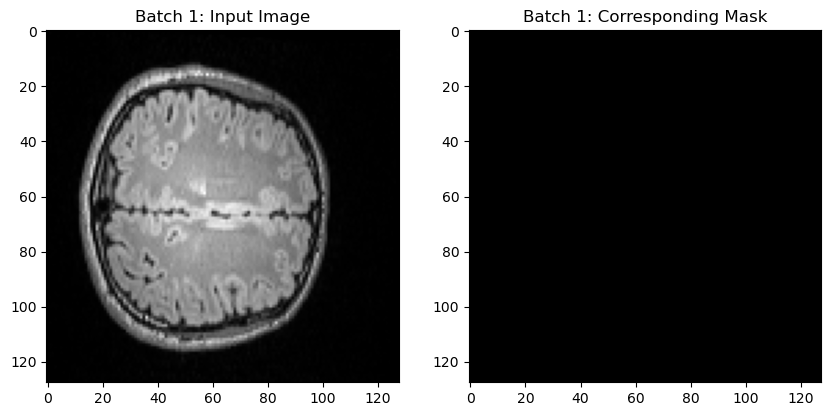

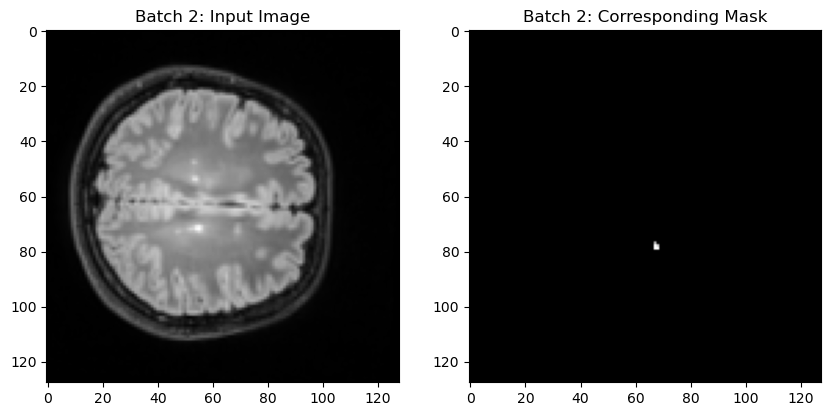

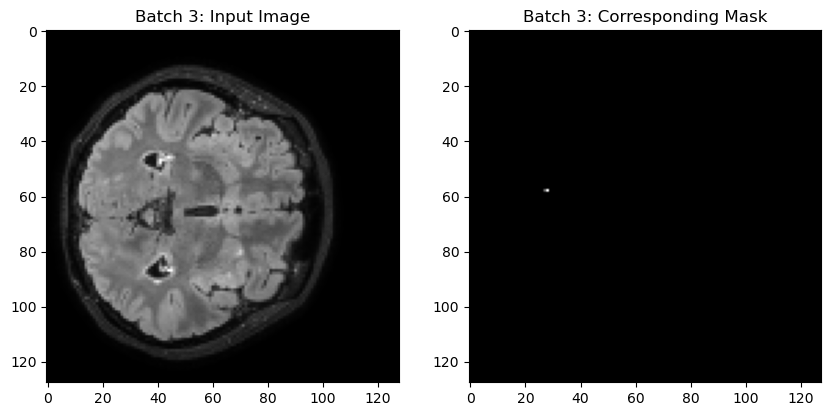

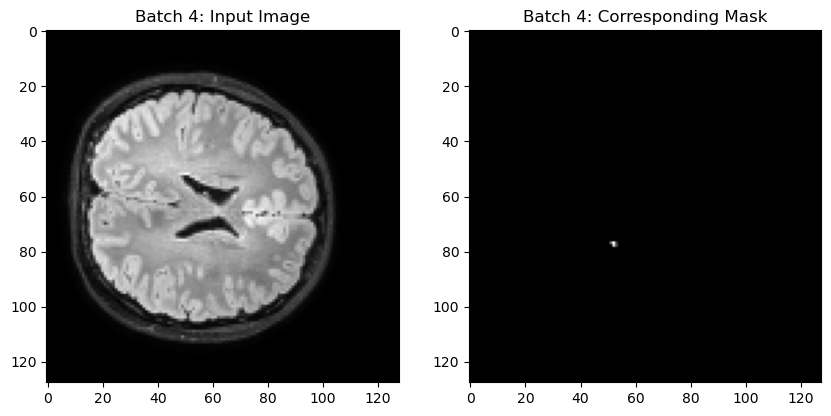

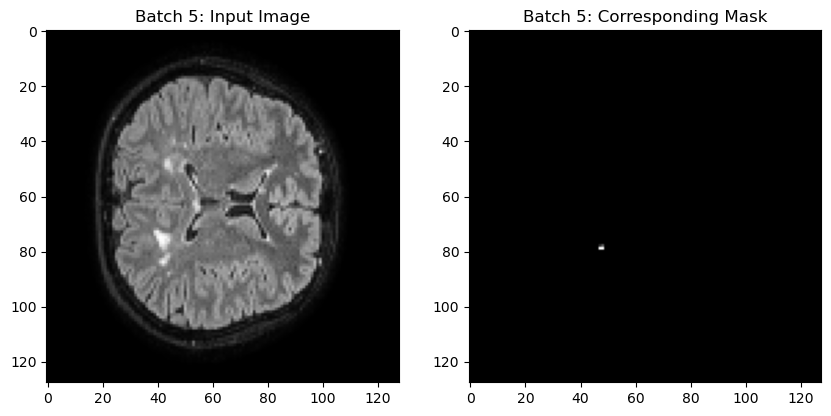

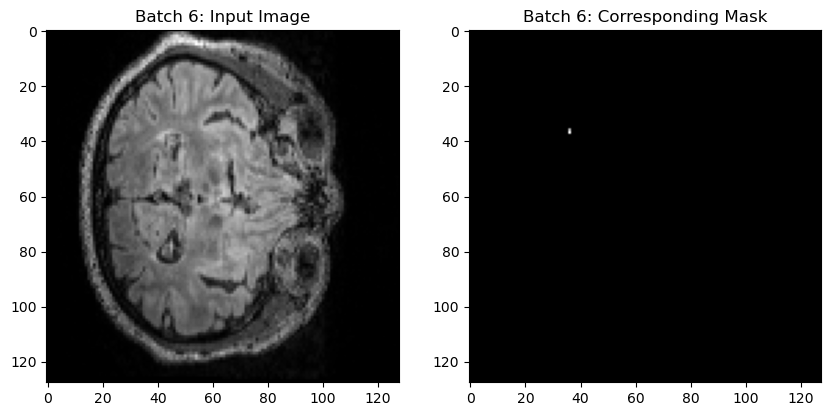

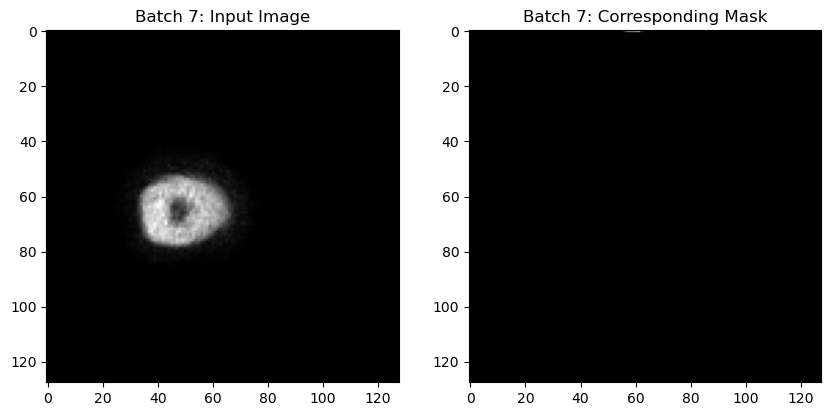

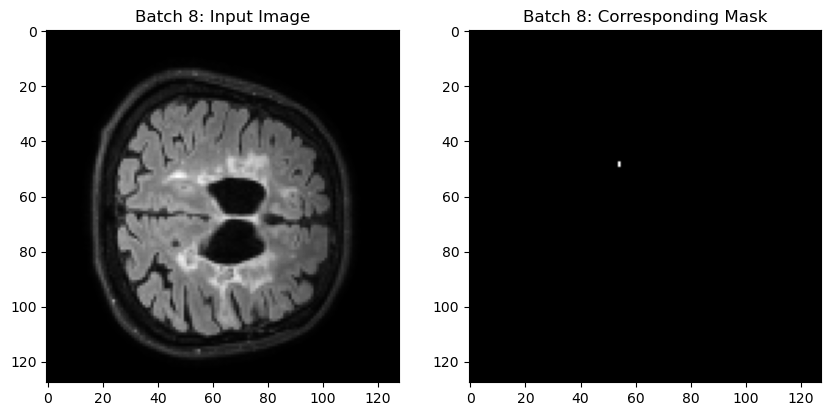

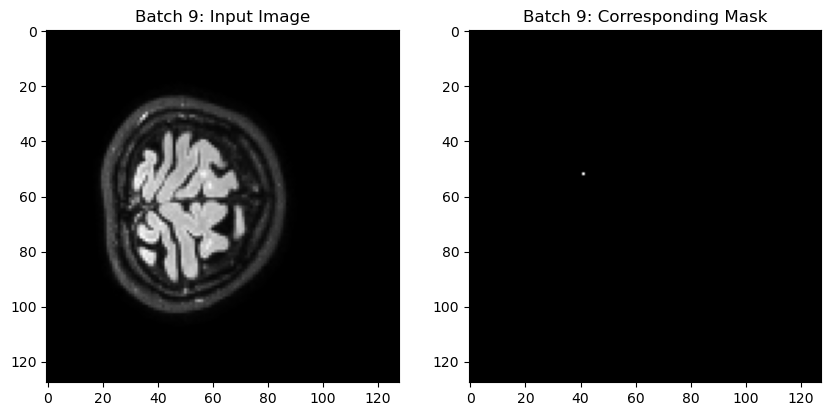

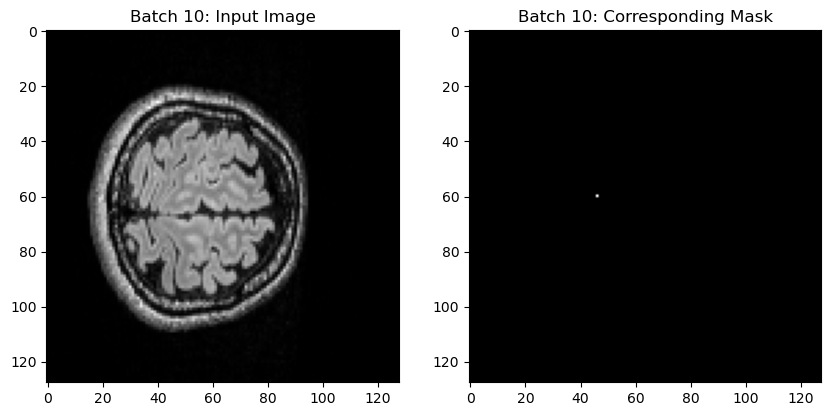

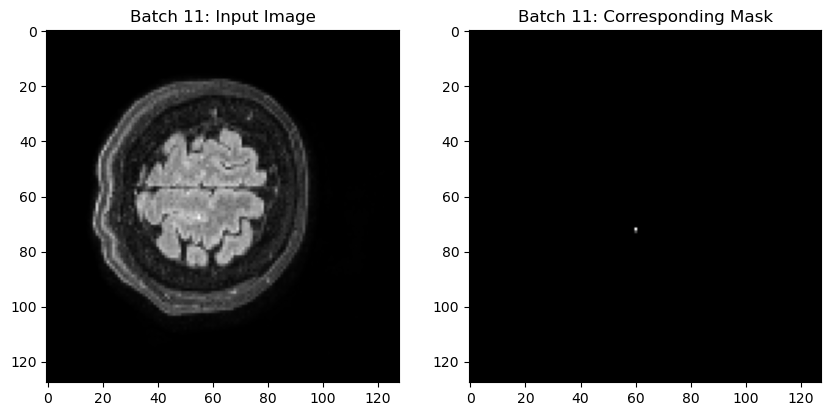

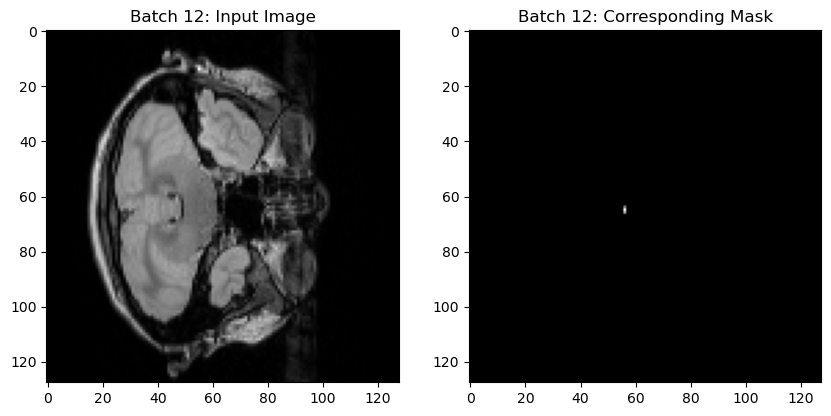

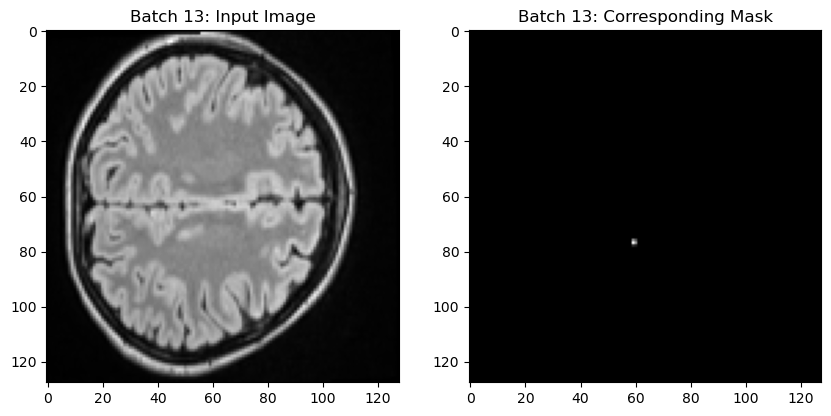

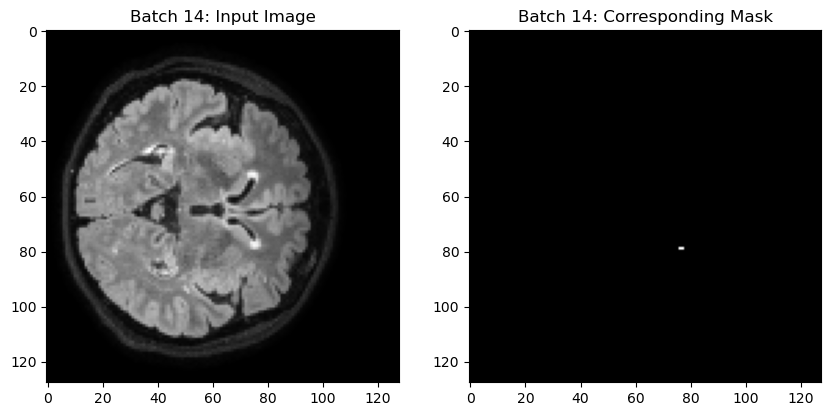

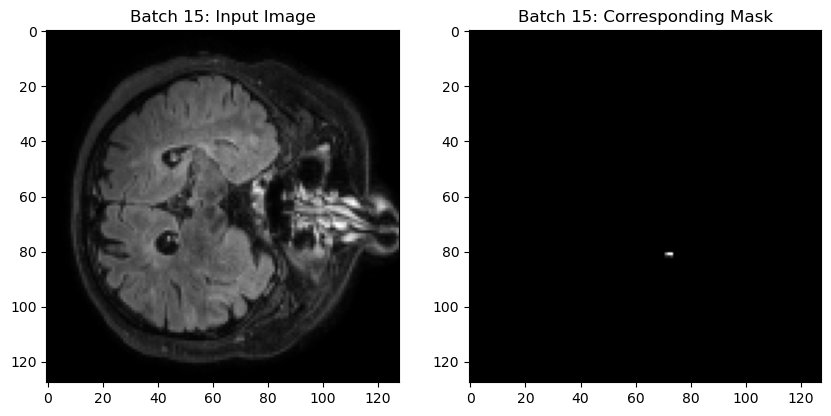

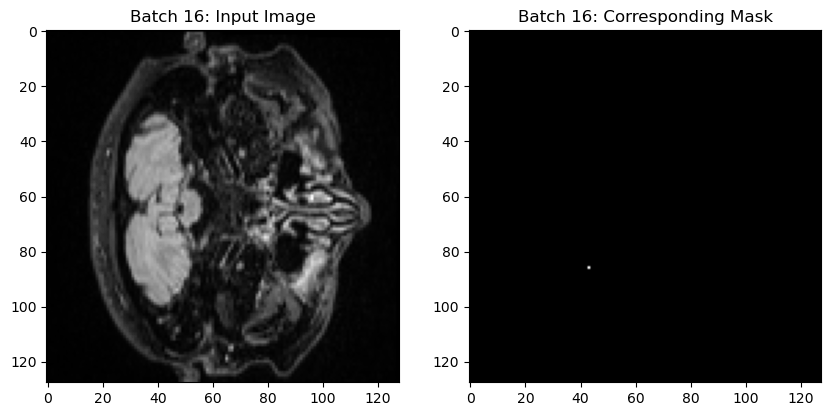

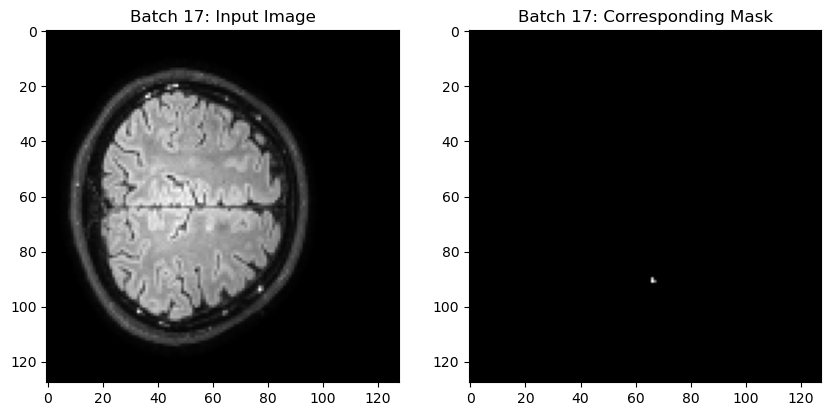

In [33]:
# Retrieve the number of batches
num_batches = len(training_generator)

# Iterate over each batch
for batch_index in range(num_batches):

    X_batch, Y_batch = training_generator.__getitem__(batch_index)

    # Visualise a sample from the batch
    sample_index = 0  

    # Display the input image and corresponding mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(X_batch[sample_index, :, :, 0], cmap='gray')
    plt.title(f'Batch {batch_index + 1}: Input Image')
    plt.subplot(1, 2, 2)
    plt.imshow(Y_batch[sample_index, :, :, 0], cmap='gray')
    plt.title(f'Batch {batch_index + 1}: Corresponding Mask')
    plt.show()

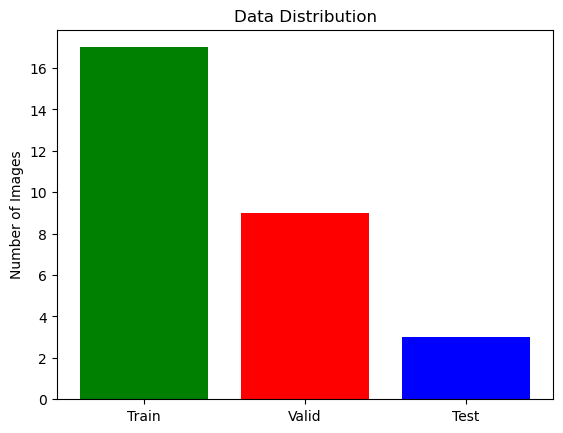

In [34]:
# Plot a chart displaying the number of images in each set
def showDataLayout():
    plt.bar(["Train", "Valid", "Test"],
            [len(train_ids), len(val_ids), len(test_ids)],
            align='center',
            color=['green', 'red', 'blue'])

    plt.ylabel('Number of Images')
    plt.title('Data Distribution')

    plt.show()

showDataLayout()

# Initiate a Pretrained U-Net Model (Transfer Learning)

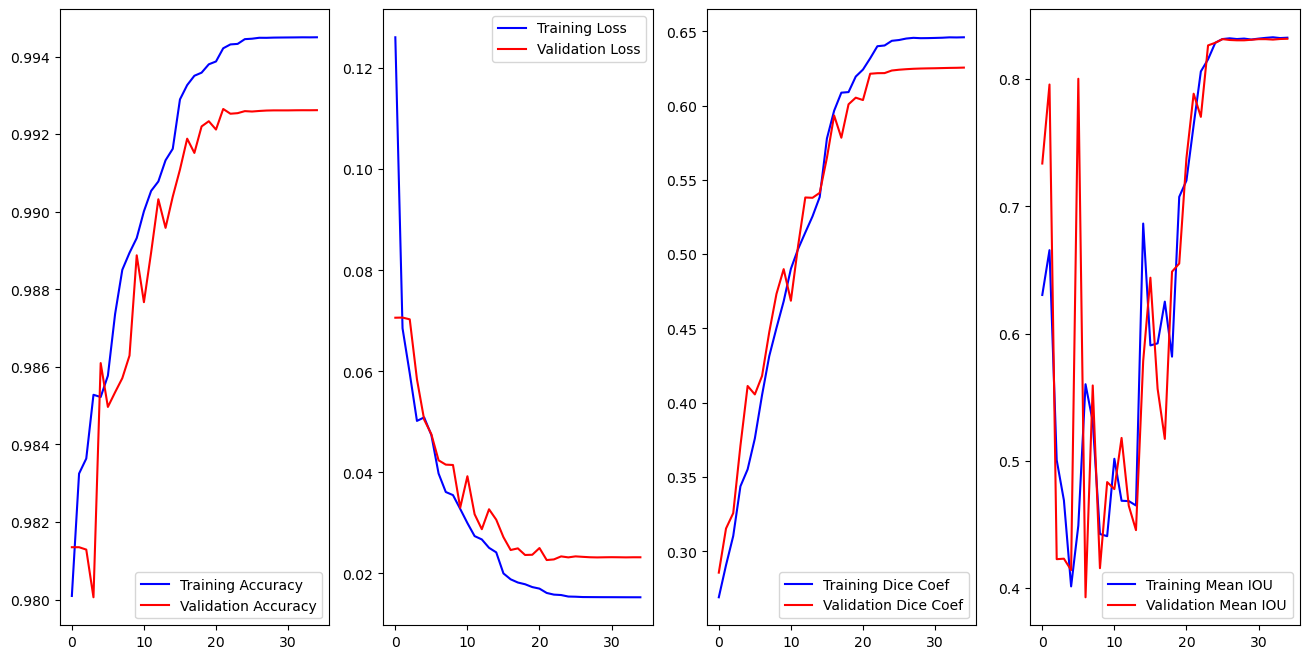

In [35]:
# Load the trained model
model = keras.models.load_model(
    '/Users/eridon/Desktop/LongitudinalMultipleSclerosisLesionSegmentationChallengeMiccai21/model_per_class.h5',
    custom_objects={
        'accuracy': tf.keras.metrics.MeanIoU(num_classes=2),
        "dice_coef": dice_coef, 
        "precision": precision,  
        "sensitivity": sensitivity, 
        "specificity": specificity 
    },
    compile=False 
)

# Load the training history
history = pd.read_csv('/Users/eridon/Desktop/LongitudinalMultipleSclerosisLesionSegmentationChallengeMiccai21/training_per_class.log', sep=',', engine='python')

# Copy the history for easier reference
hist = history

# Extract data from the history 
acc = hist['accuracy']
val_acc = hist['val_accuracy']
epoch = range(len(acc))
loss = hist['loss']
val_loss = hist['val_loss']
train_dice = hist['dice_coef']
val_dice = hist['val_dice_coef']

# Create subplots for the different metrics
f, ax = plt.subplots(1, 4, figsize=(16, 8))

# Plot training and validation accuracy
ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()

# Plot training and validation loss
ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()

# Plot training and validation Dice coefficient
ax[2].plot(epoch, train_dice, 'b', label='Training Dice Coef')
ax[2].plot(epoch, val_dice, 'r', label='Validation Dice Coef')
ax[2].legend()

# Plot training and validation mean IoU
ax[3].plot(epoch, hist['mean_io_u'], 'b', label='Training Mean IOU')
ax[3].plot(epoch, hist['val_mean_io_u'], 'r', label='Validation Mean IOU')
ax[3].legend()

# Show the plots
plt.show()

In [50]:
# Print a summary of the U-Net model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         608       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

 conv2d_20 (Conv2D)          (None, 128, 128, 32)         18464     ['concatenate_3[0][0]']       
                                                                                                  
 conv2d_21 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_20[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)          (None, 128, 128, 4)          132       ['conv2d_21[0][0]']           
                                                                                                  
Total params: 7759908 (29.60 MB)
Trainable params: 132 (528.00 Byte)
Non-trainable params: 7759776 (29.60 MB)
__________________________________________________________________________________________________


## Modify the U-Net Model

In [85]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

# Create a truncated model by removing the final layer
trunc_model = Model(model.input, model.layers[-2].output)

# Set the truncated model as non-trainable
trunc_model.trainable = False

# Initialize a sequential model
modified_model = Sequential()

# Append the truncated model to the new model
modified_model.add(trunc_model)

modified_model.add(Dense(2, activation='softmax'))

# Print a summary of the modified model
modified_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_8 (Functional)        (None, 128, 128, 32)      7759776   
                                                                 
 dense_8 (Dense)             (None, 128, 128, 2)       66        
                                                                 
Total params: 7759842 (29.60 MB)
Trainable params: 66 (264.00 Byte)
Non-trainable params: 7759776 (29.60 MB)
_________________________________________________________________


In [207]:
# Compile the model
modified_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(), 
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        dice_coef
    ]
)

# Train the U-Net Model on MSSEG-2 Dataset

In [208]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model with early stopping
history = modified_model.fit(training_generator,
                                epochs=200,
                                validation_data=valid_generator,
                                callbacks=[early_stopping])

Epoch 1/10
17/17 [==============================] - 16s 922ms/step - loss: 0.0514 - accuracy: 0.0190 - mean_io_u_23: 0.3374 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00 - dice_coef: 6.8602e-05 - val_loss: 0.0181 - val_accuracy: 0.0056 - val_mean_io_u_23: 0.3291 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - val_dice_coef: 6.3430e-05
Epoch 2/10
17/17 [==============================] - 15s 821ms/step - loss: 0.0404 - accuracy: 0.0196 - mean_io_u_23: 0.3397 - precision_22: 3.5903e-06 - recall_22: 0.0189 - dice_coef: 6.9139e-05 - val_loss: 0.0139 - val_accuracy: 0.0056 - val_mean_io_u_23: 0.3312 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - val_dice_coef: 6.3553e-05
Epoch 3/10
17/17 [==============================] - 14s 797ms/step - loss: 0.0327 - accuracy: 0.0200 - mean_io_u_23: 0.3420 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00 - dice_coef: 6.8193e-05 - val_loss: 0.0110 - val_accuracy: 0.0056 - val_mean_io_u_23: 0.3328 - val_precision_22: 0.0000

In [209]:
# Save the modified model
modified_model.save('unet_ms_segmentation_model.keras')

## Evaluate the Model

In [210]:
# Extract data from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_mean_io_u = history.history['mean_io_u_1']
val_mean_io_u = history.history['val_mean_io_u_1']
train_dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

# Get the number of epochs completed
epochs_completed = len(train_loss)
epochs = range(epochs_completed)

# Define the metrics to plot
metrics = {
    'Loss': (train_loss, val_loss),
    'Accuracy': (train_accuracy, val_accuracy),
    'Mean IoU': (train_mean_io_u, val_mean_io_u),
    'Dice Coef': (train_dice_coef, val_dice_coef)
}

# Create subplots for the different metrics
f, ax = plt.subplots(1, len(metrics), figsize=(24, 6))

# Plot each metric
for i, (metric_name, (train_metric, val_metric)) in enumerate(metrics.items()):
    ax[i].plot(epochs, train_metric, 'b', label='Training ' + metric_name)
    ax[i].plot(epochs, val_metric, 'r', label='Validation ' + metric_name)
    ax[i].legend()
    ax[i].set_title('Training and Validation ' + metric_name)
    ax[i].set_xlabel('Epochs')

# Show the plots
plt.show()

KeyError: 'mean_io_u_1'

In [211]:
# Generate predictions
MS = modified_model.predict(test_generator)

3/3 [==============================] - 1s 552ms/step


In [212]:
# Output the numerical predictions
print(MS)

[[[[2.59960651e-01 7.40039349e-01]
   [9.86894476e-04 9.99013066e-01]
   [4.50858570e-05 9.99954939e-01]
   ...
   [4.01449252e-05 9.99959826e-01]
   [8.20343848e-06 9.99991775e-01]
   [1.85081717e-05 9.99981523e-01]]

  [[1.10831403e-03 9.98891652e-01]
   [3.11305570e-07 9.99999642e-01]
   [1.30878588e-08 1.00000000e+00]
   ...
   [2.87347657e-08 1.00000000e+00]
   [1.84254656e-08 1.00000000e+00]
   [3.56232135e-07 9.99999642e-01]]

  [[4.55812056e-04 9.99544203e-01]
   [1.95544189e-07 9.99999762e-01]
   [1.87920293e-08 1.00000000e+00]
   ...
   [2.84718062e-08 1.00000000e+00]
   [1.55509952e-08 1.00000000e+00]
   [2.85533901e-07 9.99999762e-01]]

  ...

  [[4.81986767e-03 9.95180130e-01]
   [1.77012200e-08 1.00000000e+00]
   [2.46262559e-11 1.00000000e+00]
   ...
   [3.43486142e-11 1.00000000e+00]
   [4.02522026e-12 1.00000000e+00]
   [4.51015308e-10 1.00000000e+00]]

  [[4.75111801e-06 9.99995232e-01]
   [1.43026910e-11 1.00000000e+00]
   [1.16930242e-13 1.00000000e+00]
   ...
   [2

1/1 [==============================] - 0s 34ms/step


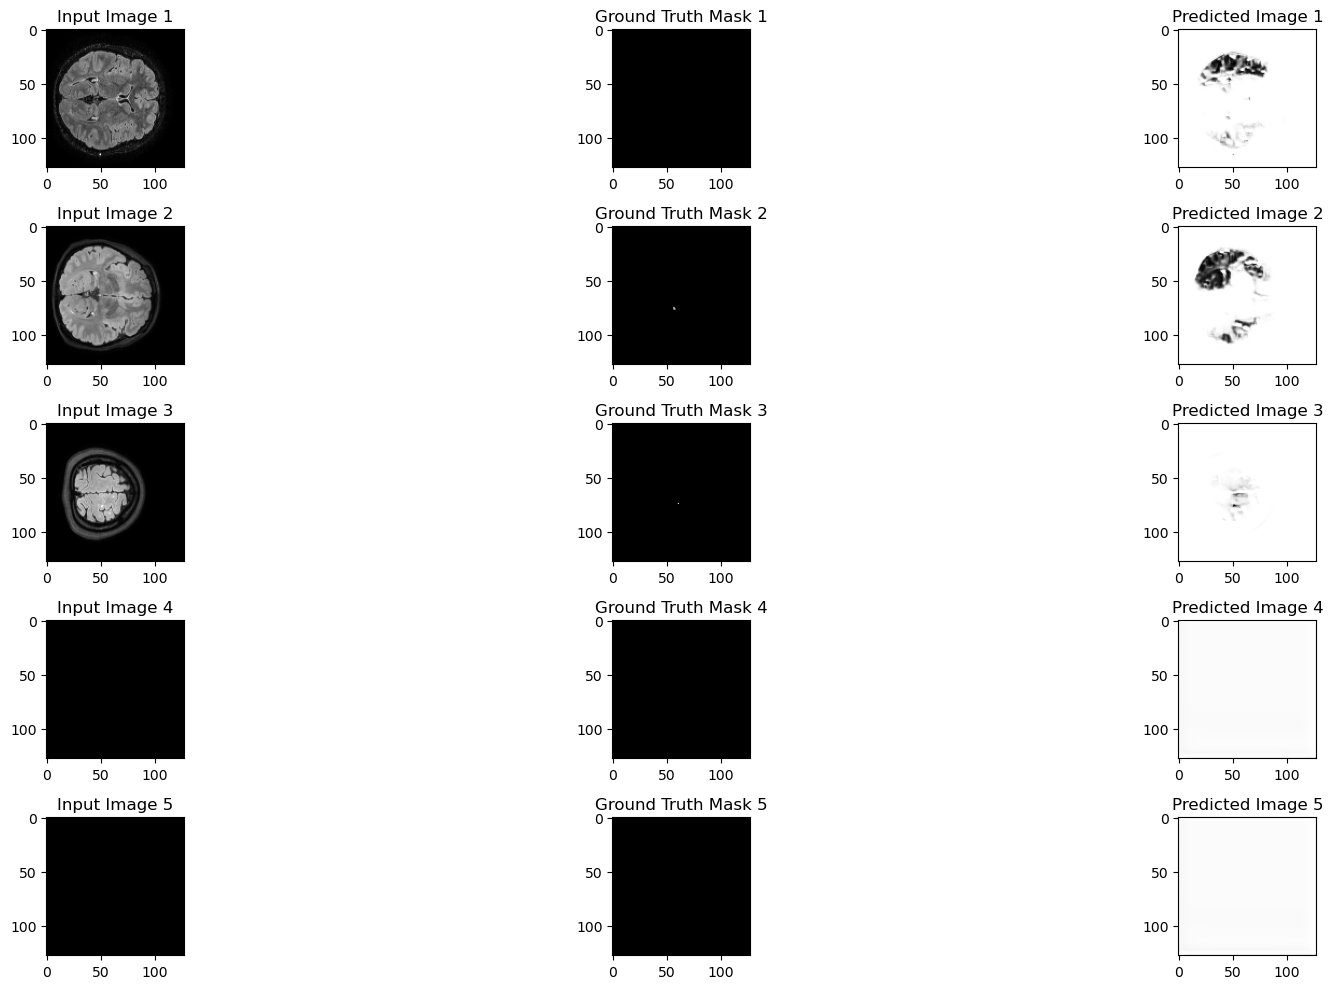

In [213]:
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size
plt.figure(figsize=(20, 10))

# Loop over each sample in the test dataset
for i in range(5):
    # Generate one batch of data
    X, Y_true = test_generator.__getitem__(i)
    
    # Predict the mask for the input image
    Y_pred = modified_model.predict(X)
    
    # Display input image
    plt.subplot(5, 3, i * 3 + 1)
    plt.title('Input Image {}'.format(i+1))
    plt.imshow(np.squeeze(X[0, :, :, 0]), cmap='gray')  

    # Display ground truth mask
    plt.subplot(5, 3, i * 3 + 2)
    plt.title('Ground Truth Mask {}'.format(i+1))
    plt.imshow(np.squeeze(Y_true[0, :, :, 0]), cmap='gray')  

    # Display predicted lesion
    plt.subplot(5, 3, i * 3 + 3)
    plt.title('Predicted Image {}'.format(i+1))
    plt.imshow(np.squeeze(Y_pred[0, :, :, 1]), cmap='gray') 

# Adjust layout
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 34ms/step


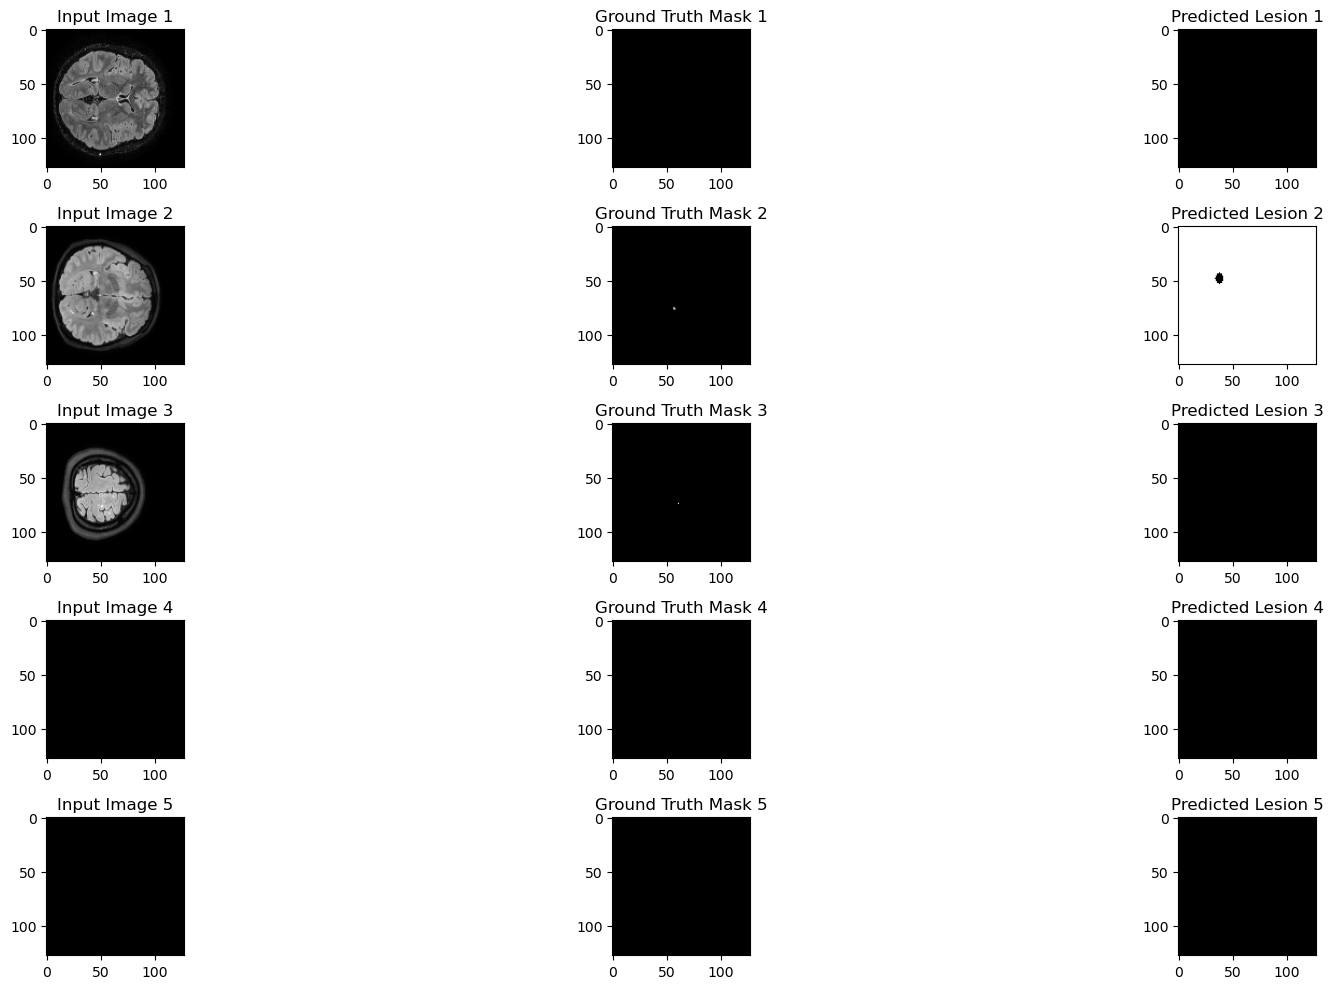

In [216]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology

# Set the figure size
plt.figure(figsize=(20, 10))

# Loop over each sample in the test dataset
for i in range(5):
    # Generate one batch of data
    X, Y_true = test_generator.__getitem__(i)
    
    # Predict the mask for the input image
    Y_pred = modified_model.predict(X)
    
    # Threshold to isolate lesions
    threshold = 0.2 
    predicted_lesion_mask = np.squeeze(Y_pred[0, :, :, 1]) > threshold
    
    # Apply morphological operations to refine the predicted mask
    predicted_lesion_mask = morphology.binary_closing(predicted_lesion_mask, morphology.disk(3))
    predicted_lesion_mask = morphology.binary_opening(predicted_lesion_mask, morphology.disk(3))
    
    # Display input image
    plt.subplot(5, 3, i * 3 + 1)
    plt.title('Input Image {}'.format(i+1))
    plt.imshow(np.squeeze(X[0, :, :, 0]), cmap='gray')  

    # Display ground truth mask
    plt.subplot(5, 3, i * 3 + 2)
    plt.title('Ground Truth Mask {}'.format(i+1))
    plt.imshow(np.squeeze(Y_true[0, :, :, 0]), cmap='gray')  

    plt.subplot(5, 3, i * 3 + 3)
    plt.title('Predicted Lesion {}'.format(i+1))
    plt.imshow(predicted_lesion_mask, cmap='gray') 

# Adjust layout
plt.tight_layout()
plt.show()

In [46]:
# Loop over each sample in the test dataset
for i in range(5):
    # Generate one batch of data
    X, Y_true = test_generator.__getitem__(i)
    
    # Predict the mask for the input image
    Y_pred = modified_model.predict(X)
    
    print("Predicted mask for sample", i+1)
    print(Y_pred)

1/1 [==============================] - 0s 32ms/step
Predicted mask for sample 1
[[[[1.0000000e+00 8.0349413e-18]
   [1.0000000e+00 2.8320607e-29]
   [1.0000000e+00 7.6439202e-34]
   ...
   [1.0000000e+00 6.8510930e-37]
   [1.0000000e+00 2.8144141e-33]
   [1.0000000e+00 1.0383062e-21]]

  [[1.0000000e+00 7.6066320e-26]
   [1.0000000e+00 0.0000000e+00]
   [1.0000000e+00 0.0000000e+00]
   ...
   [1.0000000e+00 0.0000000e+00]
   [1.0000000e+00 0.0000000e+00]
   [1.0000000e+00 2.7458792e-30]]

  [[1.0000000e+00 5.9216526e-27]
   [1.0000000e+00 0.0000000e+00]
   [1.0000000e+00 0.0000000e+00]
   ...
   [1.0000000e+00 0.0000000e+00]
   [1.0000000e+00 0.0000000e+00]
   [1.0000000e+00 4.3181894e-32]]

  ...

  [[1.0000000e+00 1.8565153e-24]
   [1.0000000e+00 0.0000000e+00]
   [1.0000000e+00 0.0000000e+00]
   ...
   [1.0000000e+00 0.0000000e+00]
   [1.0000000e+00 0.0000000e+00]
   [1.0000000e+00 2.8832262e-31]]

  [[1.0000000e+00 1.5557767e-22]
   [1.0000000e+00 3.2125619e-37]
   [1.0000000e+00 0

# Train Attention U-Net Model

In [114]:
from tensorflow.keras.layers import Layer, Conv2D, Activation, add, multiply, Input

# Define the attention block as a custom layer
class AttentionBlock(Layer):
    def __init__(self, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        # Get the shape of the input tensors
        shape_g, shape_x = input_shape

        # Define the convolutional layers for adjusting the dimensions
        self.conv_g = Conv2D(filters=shape_x[-1], kernel_size=1, strides=1, padding='same')
        self.conv_x = Conv2D(filters=shape_x[-1], kernel_size=1, strides=1, padding='same')

        super(AttentionBlock, self).build(input_shape)

    def call(self, inputs):
        g, x = inputs

        # Apply convolutional layers to adjust the dimensions
        g_conv = self.conv_g(g)
        x_conv = self.conv_x(x)

        # Compute attention map
        attn = Activation('softmax')(add([g_conv, x_conv]))

        # Apply attention to input feature map
        attn_feature_map = multiply([x, attn])
        return attn_feature_map


# Define input shape
input_shape = trunc_model.input_shape[1:]

# Define input layer
input_layer = Input(shape=input_shape)

# Apply the truncated model to the input layer
truncated_output = trunc_model(input_layer)

# Add the attention block after the truncated model
attention_output = AttentionBlock()([input_layer, truncated_output])

# Add a dense layer for classification
output = Dense(2, activation='softmax')(attention_output)

# Define the final model
attention_unet_model = Model(inputs=input_layer, outputs=output)

# Print a summary of the modified model
attention_unet_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 model_8 (Functional)        (None, 128, 128, 32)         7759776   ['input_8[0][0]']             
                                                                                                  
 attention_block_7 (Attenti  (None, 128, 128, 32)         1152      ['input_8[0][0]',             
 onBlock)                                                            'model_8[2][0]']             
                                                                                                  
 dense_10 (Dense)            (None, 128, 128, 2)          66        ['attention_block_7[0][

In [133]:
# Compile the model
attention_unet_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(), 
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        dice_coef
    ]
)

In [135]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model with early stopping
history = attention_unet_model.fit(training_generator,
                                epochs=200,
                                validation_data=valid_generator,
                                callbacks=[early_stopping])

Epoch 1/200
17/17 [==============================] - 13s 694ms/step - loss: 0.0014 - accuracy: 0.9905 - mean_io_u_14: 0.4989 - precision_13: 1.8311e-04 - recall_13: 0.9623 - dice_coef: 2.5232e-04 - val_loss: 8.3202e-04 - val_accuracy: 0.9940 - val_mean_io_u_14: 0.4901 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.2362e-04
Epoch 2/200
17/17 [==============================] - 14s 775ms/step - loss: 0.0014 - accuracy: 0.9906 - mean_io_u_14: 0.4986 - precision_13: 1.8311e-04 - recall_13: 0.9623 - dice_coef: 2.5183e-04 - val_loss: 8.2993e-04 - val_accuracy: 0.9940 - val_mean_io_u_14: 0.4898 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.2411e-04
Epoch 3/200
17/17 [==============================] - 13s 785ms/step - loss: 0.0014 - accuracy: 0.9909 - mean_io_u_14: 0.4984 - precision_13: 1.8311e-04 - recall_13: 0.9623 - dice_coef: 2.5241e-04 - val_loss: 8.2808e-04 - val_accuracy: 0.9940 - val_mean_io_u_14: 0.4892 - val_precision_13: 2.1701e

17/17 [==============================] - 13s 823ms/step - loss: 0.0014 - accuracy: 0.9910 - mean_io_u_14: 0.4427 - precision_13: 1.8311e-04 - recall_13: 0.9623 - dice_coef: 2.5898e-04 - val_loss: 7.9082e-04 - val_accuracy: 0.9940 - val_mean_io_u_14: 0.4117 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.3244e-04
Epoch 25/200
17/17 [==============================] - 13s 803ms/step - loss: 0.0013 - accuracy: 0.9911 - mean_io_u_14: 0.4340 - precision_13: 1.8311e-04 - recall_13: 0.9623 - dice_coef: 2.5952e-04 - val_loss: 7.8909e-04 - val_accuracy: 0.9940 - val_mean_io_u_14: 0.4088 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.3256e-04
Epoch 26/200
17/17 [==============================] - 13s 794ms/step - loss: 0.0014 - accuracy: 0.9910 - mean_io_u_14: 0.4284 - precision_13: 1.8311e-04 - recall_13: 0.9623 - dice_coef: 2.5966e-04 - val_loss: 7.8759e-04 - val_accuracy: 0.9940 - val_mean_io_u_14: 0.4022 - val_precision_13: 2.1701e-04 - val_

17/17 [==============================] - 13s 745ms/step - loss: 0.0013 - accuracy: 0.9908 - mean_io_u_14: 0.3737 - precision_13: 1.7952e-04 - recall_13: 0.9434 - dice_coef: 2.6132e-04 - val_loss: 7.5954e-04 - val_accuracy: 0.9937 - val_mean_io_u_14: 0.3609 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.3740e-04
Epoch 48/200
17/17 [==============================] - 14s 859ms/step - loss: 0.0013 - accuracy: 0.9908 - mean_io_u_14: 0.3733 - precision_13: 1.8311e-04 - recall_13: 0.9623 - dice_coef: 2.6352e-04 - val_loss: 7.5818e-04 - val_accuracy: 0.9937 - val_mean_io_u_14: 0.3603 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.3757e-04
Epoch 49/200
17/17 [==============================] - 13s 812ms/step - loss: 0.0013 - accuracy: 0.9906 - mean_io_u_14: 0.3725 - precision_13: 1.8311e-04 - recall_13: 0.9623 - dice_coef: 2.6369e-04 - val_loss: 7.5706e-04 - val_accuracy: 0.9938 - val_mean_io_u_14: 0.3598 - val_precision_13: 2.1701e-04 - val_

17/17 [==============================] - 13s 823ms/step - loss: 0.0012 - accuracy: 0.9907 - mean_io_u_14: 0.3622 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6535e-04 - val_loss: 7.3393e-04 - val_accuracy: 0.9933 - val_mean_io_u_14: 0.3492 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.4037e-04
Epoch 71/200
17/17 [==============================] - 14s 826ms/step - loss: 0.0012 - accuracy: 0.9905 - mean_io_u_14: 0.3615 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6531e-04 - val_loss: 7.3282e-04 - val_accuracy: 0.9933 - val_mean_io_u_14: 0.3487 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.4047e-04
Epoch 72/200
17/17 [==============================] - 13s 785ms/step - loss: 0.0012 - accuracy: 0.9903 - mean_io_u_14: 0.3611 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6550e-04 - val_loss: 7.3187e-04 - val_accuracy: 0.9933 - val_mean_io_u_14: 0.3482 - val_precision_13: 2.1701e-04 - val_

17/17 [==============================] - 14s 843ms/step - loss: 0.0012 - accuracy: 0.9900 - mean_io_u_14: 0.3505 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6671e-04 - val_loss: 7.1197e-04 - val_accuracy: 0.9929 - val_mean_io_u_14: 0.3383 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.4229e-04
Epoch 94/200
17/17 [==============================] - 13s 810ms/step - loss: 0.0012 - accuracy: 0.9902 - mean_io_u_14: 0.3498 - precision_13: 1.8311e-04 - recall_13: 0.9623 - dice_coef: 2.6558e-04 - val_loss: 7.1113e-04 - val_accuracy: 0.9928 - val_mean_io_u_14: 0.3377 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.4238e-04
Epoch 95/200
17/17 [==============================] - 13s 752ms/step - loss: 0.0012 - accuracy: 0.9901 - mean_io_u_14: 0.3491 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6666e-04 - val_loss: 7.1018e-04 - val_accuracy: 0.9929 - val_mean_io_u_14: 0.3372 - val_precision_13: 2.1701e-04 - val_

17/17 [==============================] - 15s 799ms/step - loss: 0.0011 - accuracy: 0.9895 - mean_io_u_14: 0.3391 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6742e-04 - val_loss: 6.9249e-04 - val_accuracy: 0.9923 - val_mean_io_u_14: 0.3279 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.4371e-04
Epoch 117/200
17/17 [==============================] - 13s 741ms/step - loss: 0.0011 - accuracy: 0.9893 - mean_io_u_14: 0.3388 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6780e-04 - val_loss: 6.9159e-04 - val_accuracy: 0.9923 - val_mean_io_u_14: 0.3276 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.4375e-04
Epoch 118/200
17/17 [==============================] - 15s 884ms/step - loss: 0.0011 - accuracy: 0.9893 - mean_io_u_14: 0.3382 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6768e-04 - val_loss: 6.9089e-04 - val_accuracy: 0.9922 - val_mean_io_u_14: 0.3273 - val_precision_13: 2.1701e-04 - va

17/17 [==============================] - 14s 851ms/step - loss: 0.0011 - accuracy: 0.9883 - mean_io_u_14: 0.3299 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6696e-04 - val_loss: 6.7535e-04 - val_accuracy: 0.9916 - val_mean_io_u_14: 0.3206 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.4486e-04
Epoch 140/200
17/17 [==============================] - 14s 867ms/step - loss: 0.0011 - accuracy: 0.9883 - mean_io_u_14: 0.3296 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6750e-04 - val_loss: 6.7475e-04 - val_accuracy: 0.9916 - val_mean_io_u_14: 0.3203 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.4491e-04
Epoch 141/200
17/17 [==============================] - 13s 789ms/step - loss: 0.0011 - accuracy: 0.9880 - mean_io_u_14: 0.3295 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6774e-04 - val_loss: 6.7425e-04 - val_accuracy: 0.9916 - val_mean_io_u_14: 0.3200 - val_precision_13: 2.1701e-04 - va

17/17 [==============================] - 13s 787ms/step - loss: 0.0010 - accuracy: 0.9871 - mean_io_u_14: 0.3230 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6788e-04 - val_loss: 6.6166e-04 - val_accuracy: 0.9910 - val_mean_io_u_14: 0.3146 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.4506e-04
Epoch 163/200
17/17 [==============================] - 14s 831ms/step - loss: 0.0010 - accuracy: 0.9870 - mean_io_u_14: 0.3231 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6692e-04 - val_loss: 6.6107e-04 - val_accuracy: 0.9909 - val_mean_io_u_14: 0.3145 - val_precision_13: 2.1701e-04 - val_recall_13: 1.0000 - val_dice_coef: 2.4500e-04
Epoch 164/200
17/17 [==============================] - 13s 785ms/step - loss: 0.0010 - accuracy: 0.9872 - mean_io_u_14: 0.3226 - precision_13: 1.8670e-04 - recall_13: 0.9811 - dice_coef: 2.6787e-04 - val_loss: 6.6075e-04 - val_accuracy: 0.9909 - val_mean_io_u_14: 0.3141 - val_precision_13: 2.1701e-04 - va

17/17 [==============================] - 13s 781ms/step - loss: 9.8034e-04 - accuracy: 0.9854 - mean_io_u_14: 0.3169 - precision_13: 1.8311e-04 - recall_13: 0.9623 - dice_coef: 2.6747e-04 - val_loss: 6.5158e-04 - val_accuracy: 0.9897 - val_mean_io_u_14: 0.3090 - val_precision_13: 2.1023e-04 - val_recall_13: 0.9688 - val_dice_coef: 2.4049e-04
Epoch 186/200
17/17 [==============================] - 13s 794ms/step - loss: 9.6754e-04 - accuracy: 0.9849 - mean_io_u_14: 0.3166 - precision_13: 1.8311e-04 - recall_13: 0.9623 - dice_coef: 2.6690e-04 - val_loss: 6.5102e-04 - val_accuracy: 0.9897 - val_mean_io_u_14: 0.3088 - val_precision_13: 2.1023e-04 - val_recall_13: 0.9688 - val_dice_coef: 2.4051e-04
Epoch 187/200
17/17 [==============================] - 13s 802ms/step - loss: 9.6094e-04 - accuracy: 0.9853 - mean_io_u_14: 0.3161 - precision_13: 1.7592e-04 - recall_13: 0.9245 - dice_coef: 2.6124e-04 - val_loss: 6.5015e-04 - val_accuracy: 0.9899 - val_mean_io_u_14: 0.3086 - val_precision_13: 2.1

In [136]:
# Generate predictions
MS1 = attention_unet_model.predict(test_generator)

3/3 [==============================] - 1s 531ms/step


In [137]:
# Output the numerical predictions
print(MS1)

[[[[9.98655081e-01 1.34485064e-03]
   [1.00000000e+00 3.08028039e-12]
   [1.00000000e+00 1.50486804e-14]
   ...
   [1.00000000e+00 7.35348519e-15]
   [1.00000000e+00 2.01477919e-12]
   [1.00000000e+00 5.66281315e-08]]

  [[1.00000000e+00 2.61251798e-10]
   [1.00000000e+00 9.00853040e-18]
   [1.00000000e+00 9.56876070e-21]
   ...
   [1.00000000e+00 1.43197061e-21]
   [1.00000000e+00 3.89847907e-18]
   [1.00000000e+00 1.36991269e-11]]

  [[1.00000000e+00 6.46345061e-11]
   [1.00000000e+00 1.06512646e-18]
   [1.00000000e+00 9.95076668e-22]
   ...
   [1.00000000e+00 3.28160078e-23]
   [1.00000000e+00 8.54736907e-20]
   [1.00000000e+00 1.22107240e-12]]

  ...

  [[1.00000000e+00 6.22284224e-10]
   [1.00000000e+00 8.36289360e-18]
   [1.00000000e+00 1.54178711e-21]
   ...
   [1.00000000e+00 2.60767300e-22]
   [1.00000000e+00 1.00914135e-19]
   [1.00000000e+00 8.25911713e-13]]

  [[1.00000000e+00 2.60911803e-09]
   [1.00000000e+00 5.10052959e-16]
   [1.00000000e+00 5.57420109e-19]
   ...
   [1

1/1 [==============================] - 0s 35ms/step


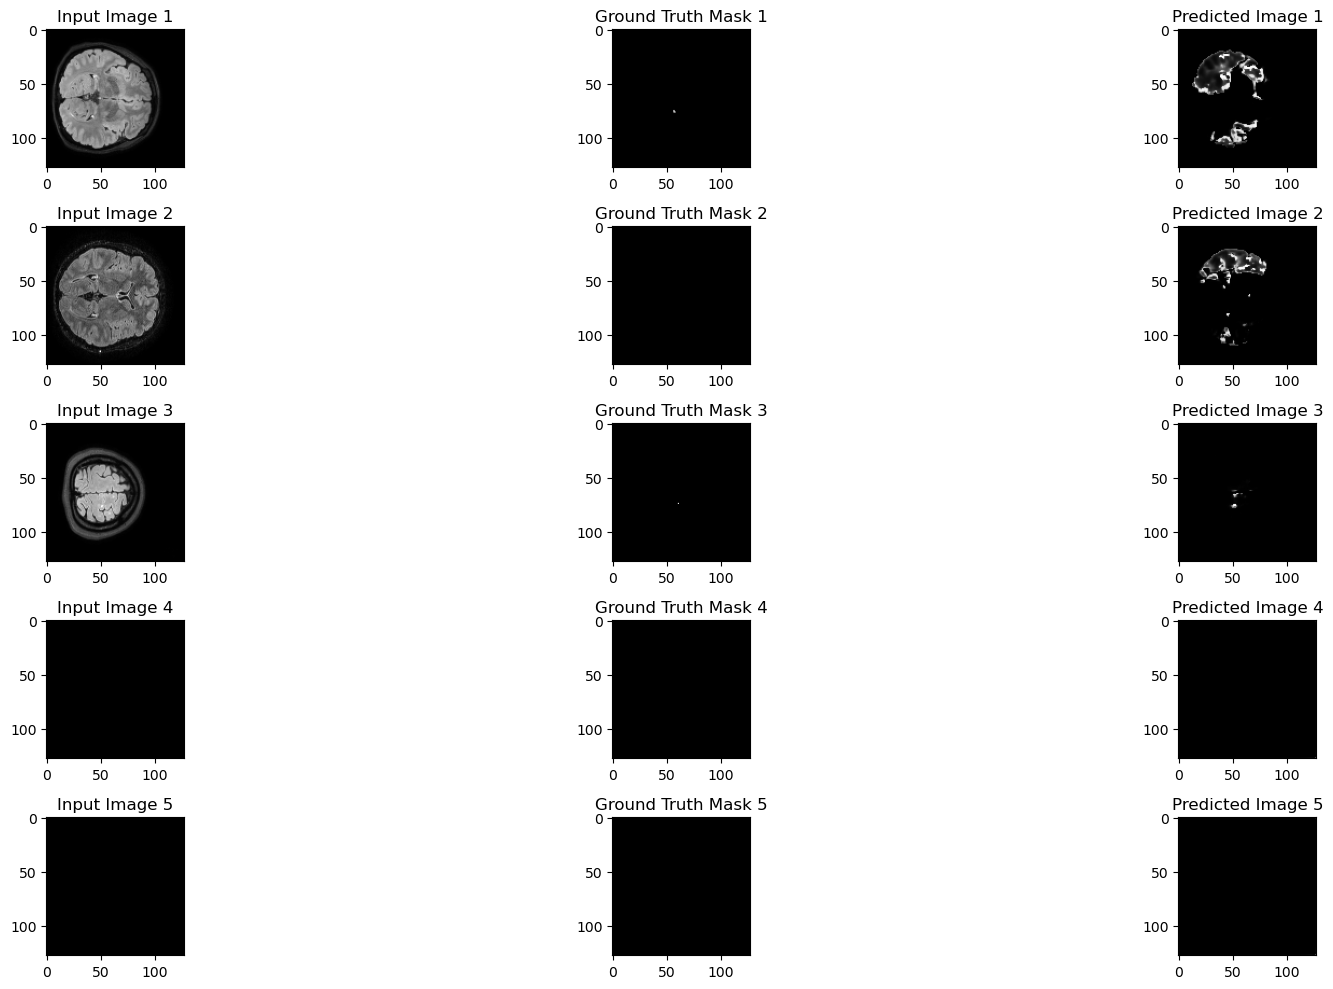

In [138]:
plt.figure(figsize=(20, 10))

# Loop over each sample in the test dataset
for i in range(5):
    # Generate one batch of data
    X, Y_true = test_generator.__getitem__(i)
    
    # Predict the mask for the input image
    Y_pred = attention_unet_model.predict(X)
    
    # Display input image
    plt.subplot(5, 3, i * 3 + 1)
    plt.title('Input Image {}'.format(i+1))
    plt.imshow(np.squeeze(X[0, :, :, 0]), cmap='gray')  

    # Display ground truth mask
    plt.subplot(5, 3, i * 3 + 2)
    plt.title('Ground Truth Mask {}'.format(i+1))
    plt.imshow(np.squeeze(Y_true[0, :, :, 0]), cmap='gray')  

    # Display predicted lesion
    plt.subplot(5, 3, i * 3 + 3)
    plt.title('Predicted Image {}'.format(i+1))
    plt.imshow(np.squeeze(Y_pred[0, :, :, 1]), cmap='gray') 

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 35ms/step


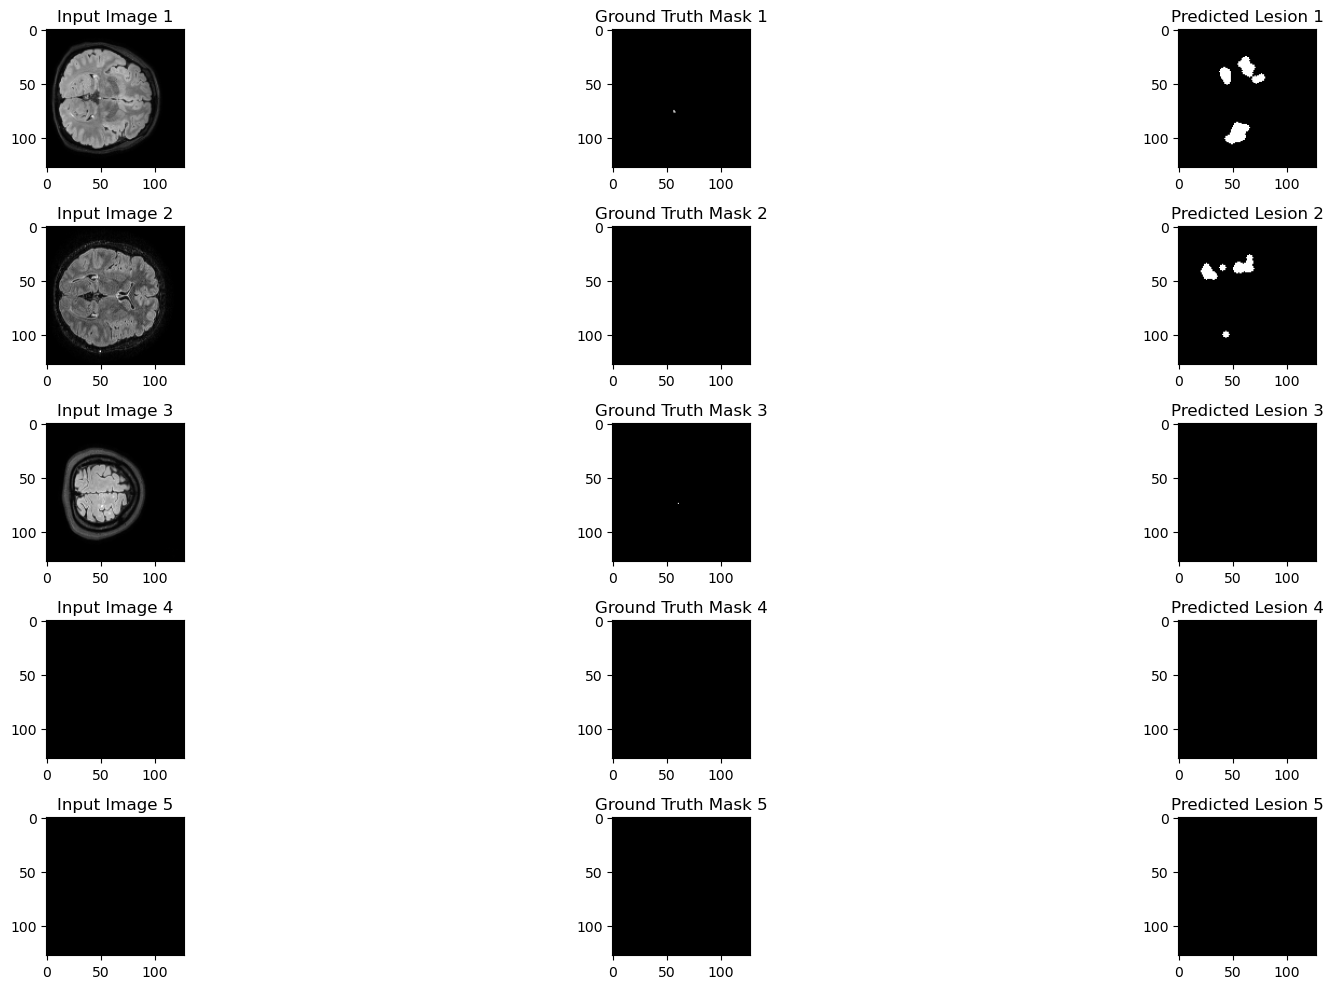

In [199]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology

plt.figure(figsize=(20, 10))

# Loop over each sample in the test dataset
for i in range(5):
    # Generate one batch of data
    X, Y_true = test_generator.__getitem__(i)
    
    # Predict the mask for the input image
    Y_pred = attention_unet_model.predict(X)
    
    # Threshold to isolate lesions
    threshold = 0.4
    predicted_lesion_mask = np.squeeze(Y_pred[0, :, :, 1]) > threshold
    
    # Apply morphological operations to refine the predicted mask
    predicted_lesion_mask = morphology.binary_closing(predicted_lesion_mask, morphology.disk(3))
    predicted_lesion_mask = morphology.binary_opening(predicted_lesion_mask, morphology.disk(3))
    
    # Display input image
    plt.subplot(5, 3, i * 3 + 1)
    plt.title('Input Image {}'.format(i+1))
    plt.imshow(np.squeeze(X[0, :, :, 0]), cmap='gray')  

    # Display ground truth mask
    plt.subplot(5, 3, i * 3 + 2)
    plt.title('Ground Truth Mask {}'.format(i+1))
    plt.imshow(np.squeeze(Y_true[0, :, :, 0]), cmap='gray')  

    plt.subplot(5, 3, i * 3 + 3)
    plt.title('Predicted Lesion {}'.format(i+1))
    plt.imshow(predicted_lesion_mask, cmap='gray') 

# Adjust layout
plt.tight_layout()
plt.show()

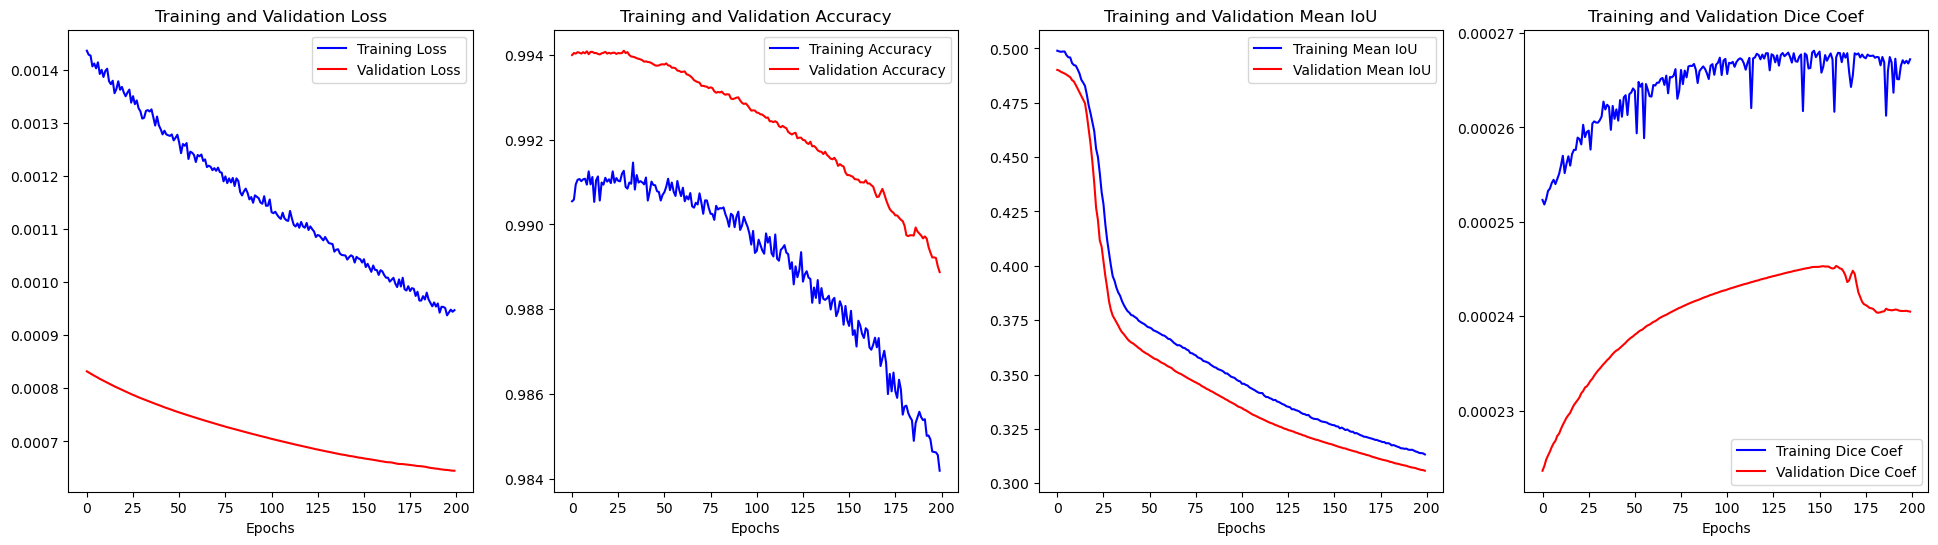

In [143]:
# Extract data from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_mean_io_u = history.history['mean_io_u_14']
val_mean_io_u = history.history['val_mean_io_u_14']
train_dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

# Get the number of epochs completed
epochs_completed = len(train_loss)
epochs = range(epochs_completed)

# Define the metrics to plot
metrics = {
    'Loss': (train_loss, val_loss),
    'Accuracy': (train_accuracy, val_accuracy),
    'Mean IoU': (train_mean_io_u, val_mean_io_u),
    'Dice Coef': (train_dice_coef, val_dice_coef)
}

# Create subplots for the different metrics
f, ax = plt.subplots(1, len(metrics), figsize=(24, 6))

# Plot each metric
for i, (metric_name, (train_metric, val_metric)) in enumerate(metrics.items()):
    ax[i].plot(epochs, train_metric, 'b', label='Training ' + metric_name)
    ax[i].plot(epochs, val_metric, 'r', label='Validation ' + metric_name)
    ax[i].legend()
    ax[i].set_title('Training and Validation ' + metric_name)
    ax[i].set_xlabel('Epochs')

# Show the plots
plt.show()

In [77]:
# Loop over each sample in the test dataset
for i in range(5):
    # Generate one batch of data
    X, Y_true = test_generator.__getitem__(i)
    
    # Predict the mask for the input image
    Y_pred = attention_unet_model.predict(X)
    
    print("Predicted mask for sample", i+1)
    print(Y_pred)

1/1 [==============================] - 0s 41ms/step
Predicted mask for sample 1
[[[[0.63737285 0.36262718]
   [0.7869431  0.21305688]
   [0.8209179  0.17908211]
   ...
   [0.806884   0.19311602]
   [0.7702224  0.22977757]
   [0.716338   0.28366202]]

  [[0.68212146 0.31787854]
   [0.7697585  0.23024146]
   [0.7948103  0.20518973]
   ...
   [0.78702044 0.2129795 ]
   [0.7615362  0.23846386]
   [0.68383986 0.31616017]]

  [[0.64776134 0.35223868]
   [0.75199586 0.24800414]
   [0.7744601  0.22553983]
   ...
   [0.7756608  0.22433917]
   [0.754744   0.24525605]
   [0.6825588  0.31744117]]

  ...

  [[0.59544396 0.40455604]
   [0.73667794 0.263322  ]
   [0.7593866  0.24061337]
   ...
   [0.7447587  0.25524122]
   [0.7297572  0.2702428 ]
   [0.6790323  0.32096764]]

  [[0.51500887 0.48499107]
   [0.62602246 0.3739775 ]
   [0.63206446 0.36793557]
   ...
   [0.624999   0.375001  ]
   [0.62451535 0.37548456]
   [0.5830427  0.41695735]]

  [[0.2874525  0.7125475 ]
   [0.46808836 0.5319116 ]
   [

In [ ]:
# The above code displays the likelihood of a pixel belonging to an MS lesion or normal brain tissue

# Dense Residual U-Net Model

In [191]:
from tensorflow.keras.layers import Dropout, BatchNormalization

class DenseResidualBlock(Layer):
    def __init__(self, dropout_rate=0.2, **kwargs):
        super(DenseResidualBlock, self).__init__(**kwargs)
        self.dropout_rate = dropout_rate

    def build(self, input_shape):
        _, _, _, num_channels = input_shape
        self.conv1 = Conv2D(filters=num_channels, kernel_size=3, strides=1, padding='same', activation='relu')
        self.conv2 = Conv2D(filters=num_channels, kernel_size=3, strides=1, padding='same', activation='relu')
        self.dropout = Dropout(self.dropout_rate)
        self.batch_norm = BatchNormalization()
        super(DenseResidualBlock, self).build(input_shape)

    def call(self, inputs, training=False):
        x = inputs
        conv1_output = self.conv1(x)
        conv2_output = self.conv2(conv1_output)
        residual_output = add([x, conv2_output])
        residual_output = self.batch_norm(residual_output, training=training)
        residual_output = self.dropout(residual_output, training=training)
        return residual_output

# Modify the input layer
input_layer = Input(shape=input_shape)

# Apply the truncated model to the input layer
truncated_output = trunc_model(input_layer)

# Add the dense residual block after the truncated model
residual_output = DenseResidualBlock(dropout_rate=0.2)(truncated_output)

# Add a dense layer for classification
output = Dense(2, activation='softmax')(residual_output)

# Define the final model
residual_unet_model = Model(inputs=input_layer, outputs=output)

# Print a summary of the modified model
residual_unet_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 2)]     0         
                                                                 
 model_8 (Functional)        (None, 128, 128, 32)      7759776   
                                                                 
 dense_residual_block_4 (De  (None, 128, 128, 32)      18624     
 nseResidualBlock)                                               
                                                                 
 dense_15 (Dense)            (None, 128, 128, 2)       66        
                                                                 
Total params: 7778466 (29.67 MB)
Trainable params: 18626 (72.76 KB)
Non-trainable params: 7759840 (29.60 MB)
_________________________________________________________________


In [192]:
# Compile the model
residual_unet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(), 
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        dice_coef
    ]
)

In [194]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model with early stopping
history = residual_unet_model.fit(training_generator,
                                epochs=200,
                                validation_data=valid_generator,
                                callbacks=[early_stopping])

Epoch 1/200
17/17 [==============================] - 13s 795ms/step - loss: 7.9992e-05 - accuracy: 0.4927 - mean_io_u_22: 0.5000 - precision_21: 9.3348e-05 - recall_21: 0.4906 - dice_coef: 1.7158e-04 - val_loss: 6.0433e-05 - val_accuracy: 0.2826 - val_mean_io_u_22: 0.5000 - val_precision_21: 1.6954e-04 - val_recall_21: 0.7812 - val_dice_coef: 1.6108e-04
Epoch 2/200
17/17 [==============================] - 14s 845ms/step - loss: 8.1552e-05 - accuracy: 0.4916 - mean_io_u_22: 0.5000 - precision_21: 9.3348e-05 - recall_21: 0.4906 - dice_coef: 1.6650e-04 - val_loss: 6.3471e-05 - val_accuracy: 0.6381 - val_mean_io_u_22: 0.5000 - val_precision_21: 1.0173e-04 - val_recall_21: 0.4688 - val_dice_coef: 1.5803e-04
Epoch 3/200
17/17 [==============================] - 14s 838ms/step - loss: 8.0085e-05 - accuracy: 0.4882 - mean_io_u_22: 0.5000 - precision_21: 6.8216e-05 - recall_21: 0.3585 - dice_coef: 1.6561e-04 - val_loss: 6.1716e-05 - val_accuracy: 0.6682 - val_mean_io_u_22: 0.5000 - val_precision

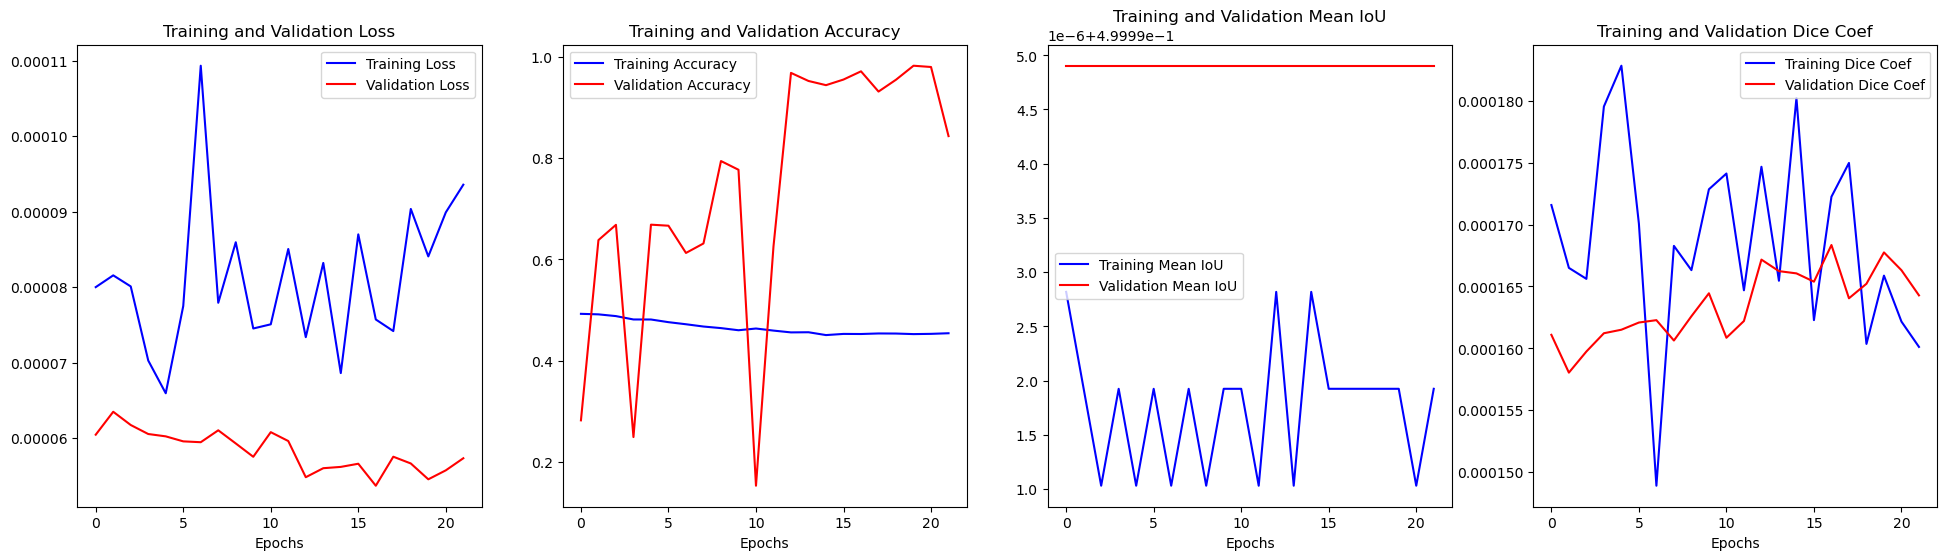

In [197]:
# Extract data from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_mean_io_u = history.history['mean_io_u_22']
val_mean_io_u = history.history['val_mean_io_u_22']
train_dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

# Get the number of epochs completed
epochs_completed = len(train_loss)
epochs = range(epochs_completed)

# Define the metrics to plot
metrics = {
    'Loss': (train_loss, val_loss),
    'Accuracy': (train_accuracy, val_accuracy),
    'Mean IoU': (train_mean_io_u, val_mean_io_u),
    'Dice Coef': (train_dice_coef, val_dice_coef)
}

# Create subplots for the different metrics
f, ax = plt.subplots(1, len(metrics), figsize=(24, 6))

# Plot each metric
for i, (metric_name, (train_metric, val_metric)) in enumerate(metrics.items()):
    ax[i].plot(epochs, train_metric, 'b', label='Training ' + metric_name)
    ax[i].plot(epochs, val_metric, 'r', label='Validation ' + metric_name)
    ax[i].legend()
    ax[i].set_title('Training and Validation ' + metric_name)
    ax[i].set_xlabel('Epochs')

# Show the plots
plt.show()

1/1 [==============================] - 0s 37ms/step


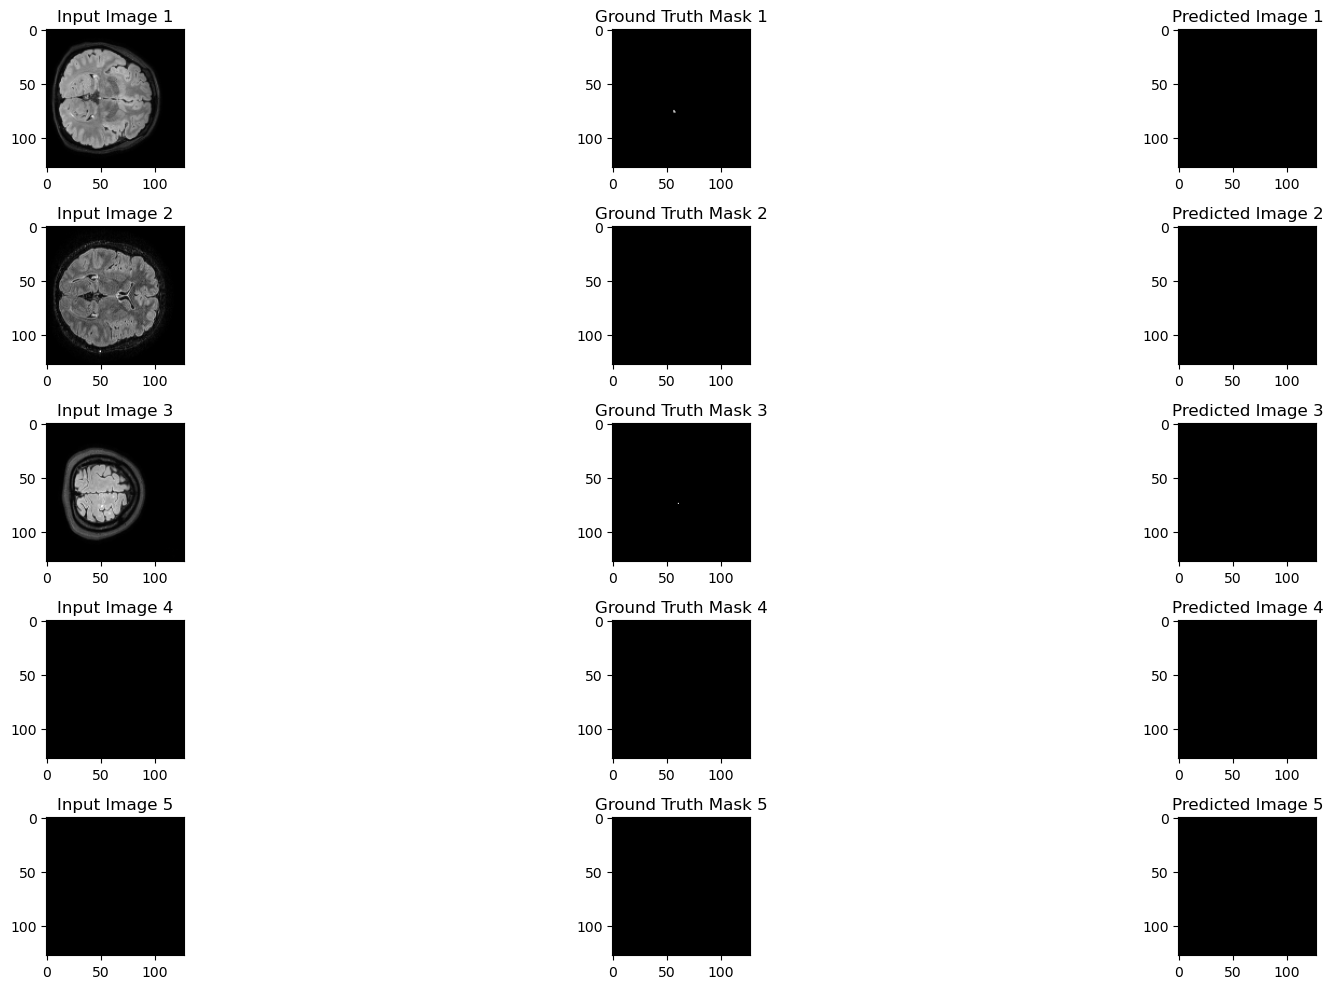

In [178]:
plt.figure(figsize=(20, 10))

# Loop over each sample in the test dataset
for i in range(5):
    # Generate one batch of data
    X, Y_true = test_generator.__getitem__(i)
    
    # Predict the mask for the input image
    Y_pred = residual_unet_model.predict(X)
    
    # Display input image
    plt.subplot(5, 3, i * 3 + 1)
    plt.title('Input Image {}'.format(i+1))
    plt.imshow(np.squeeze(X[0, :, :, 0]), cmap='gray')  

    # Display ground truth mask
    plt.subplot(5, 3, i * 3 + 2)
    plt.title('Ground Truth Mask {}'.format(i+1))
    plt.imshow(np.squeeze(Y_true[0, :, :, 0]), cmap='gray')  

    # Display predicted lesion
    plt.subplot(5, 3, i * 3 + 3)
    plt.title('Predicted Image {}'.format(i+1))
    plt.imshow(np.squeeze(Y_pred[0, :, :, 1]), cmap='gray') 

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 36ms/step


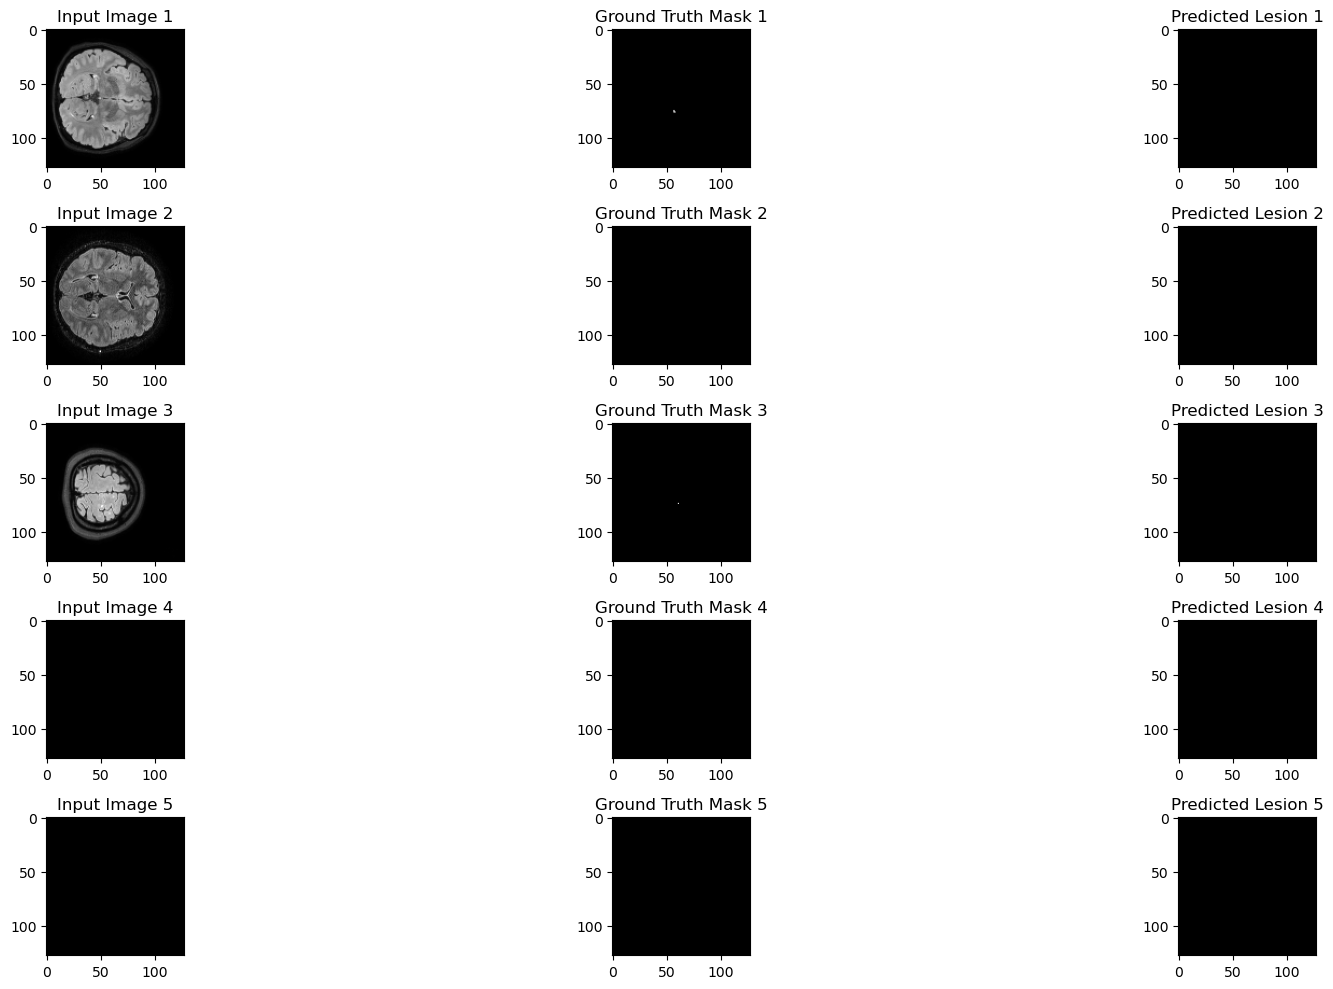

In [201]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology

plt.figure(figsize=(20, 10))

# Loop over each sample in the test dataset
for i in range(5):
    # Generate one batch of data
    X, Y_true = test_generator.__getitem__(i)
    
    # Predict the mask for the input image
    Y_pred = residual_unet_model.predict(X)
    
    # Threshold to isolate lesions
    threshold = 0.3
    predicted_lesion_mask = np.squeeze(Y_pred[0, :, :, 1]) > threshold
    
    # Apply morphological operations to refine the predicted mask
    predicted_lesion_mask = morphology.binary_closing(predicted_lesion_mask, morphology.disk(3))
    predicted_lesion_mask = morphology.binary_opening(predicted_lesion_mask, morphology.disk(3))
    
    # Display input image
    plt.subplot(5, 3, i * 3 + 1)
    plt.title('Input Image {}'.format(i+1))
    plt.imshow(np.squeeze(X[0, :, :, 0]), cmap='gray')  

    # Display ground truth mask
    plt.subplot(5, 3, i * 3 + 2)
    plt.title('Ground Truth Mask {}'.format(i+1))
    plt.imshow(np.squeeze(Y_true[0, :, :, 0]), cmap='gray')  

    # Display predicted lesion after morphological operations
    plt.subplot(5, 3, i * 3 + 3)
    plt.title('Predicted Lesion {}'.format(i+1))
    plt.imshow(predicted_lesion_mask, cmap='gray') 

# Adjust layout
plt.tight_layout()
plt.show()

# Ensemble U-Net Model

In [182]:
from tensorflow.keras.layers import Layer, Conv2D, Activation, add, multiply, Input, Dense, Concatenate
from tensorflow.keras.models import Model

# Define the dense residual block as a custom layer
class DenseResidualBlock(Layer):
    def __init__(self, **kwargs):
        super(DenseResidualBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        # Get the shape of the input tensor
        _, _, _, num_channels = input_shape

        # Define the convolutional layers
        self.conv1 = Conv2D(filters=num_channels, kernel_size=3, strides=1, padding='same', activation='relu')
        self.conv2 = Conv2D(filters=num_channels, kernel_size=3, strides=1, padding='same', activation='relu')
        
        super(DenseResidualBlock, self).build(input_shape)

    def call(self, inputs):
        x = inputs

        # First convolutional layer
        conv1_output = self.conv1(x)

        # Second convolutional layer
        conv2_output = self.conv2(conv1_output)

        # Residual connection
        residual_output = add([x, conv2_output])

        return residual_output

# Define the attention block as a custom layer
class AttentionBlock(Layer):
    def __init__(self, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        # Get the shape of the input tensors
        shape_g, shape_x = input_shape

        # Define the convolutional layers for adjusting the dimensions
        self.conv_g = Conv2D(filters=shape_x[-1], kernel_size=1, strides=1, padding='same')
        self.conv_x = Conv2D(filters=shape_x[-1], kernel_size=1, strides=1, padding='same')

        super(AttentionBlock, self).build(input_shape)

    def call(self, inputs):
        g, x = inputs

        # Apply convolutional layers to adjust the dimensions
        g_conv = self.conv_g(g)
        x_conv = self.conv_x(x)

        # Compute attention map
        attn = Activation('softmax')(add([g_conv, x_conv]))

        # Apply attention to input feature map
        attn_feature_map = multiply([x, attn])
        return attn_feature_map

# Define input shape
input_shape = trunc_model.input_shape[1:]

# Define input layer
input_layer = Input(shape=input_shape)

# Apply the truncated model to the input layer
truncated_output = trunc_model(input_layer)

# Apply the dense residual block
residual_output = DenseResidualBlock()(truncated_output)

# Apply the attention block
attention_output = AttentionBlock()([input_layer, truncated_output])

# Concatenate the outputs from both blocks
concatenated_output = Concatenate()([residual_output, attention_output])

# Add a dense layer for classification
output = Dense(2, activation='softmax')(concatenated_output)

# Define the final model
ensemble_model = Model(inputs=input_layer, outputs=output)

# Print a summary of the modified model
ensemble_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 model_8 (Functional)        (None, 128, 128, 32)         7759776   ['input_12[0][0]']            
                                                                                                  
 dense_residual_block_3 (De  (None, 128, 128, 32)         18496     ['model_8[6][0]']             
 nseResidualBlock)                                                                                
                                                                                                  
 attention_block_8 (Attenti  (None, 128, 128, 32)         1152      ['input_12[0][0]',     

In [183]:
# Compile the model
ensemble_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(), 
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=2),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        dice_coef
    ]
)

In [184]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model with early stopping
history = ensemble_model.fit(training_generator,
                                epochs=200,
                                validation_data=valid_generator,
                                callbacks=[early_stopping])

Epoch 1/200
17/17 [==============================] - 16s 900ms/step - loss: 0.7628 - accuracy: 0.2716 - mean_io_u_21: 0.4147 - precision_20: 9.6938e-05 - recall_20: 0.5094 - dice_coef: 1.5821e-04 - val_loss: 0.0014 - val_accuracy: 0.0193 - val_mean_io_u_21: 0.3632 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_dice_coef: 8.5217e-05
Epoch 2/200
17/17 [==============================] - 14s 864ms/step - loss: 0.0019 - accuracy: 0.0081 - mean_io_u_21: 0.3622 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - dice_coef: 7.5167e-05 - val_loss: 0.0010 - val_accuracy: 0.0021 - val_mean_io_u_21: 0.3451 - val_precision_20: 0.0000e+00 - val_recall_20: 0.0000e+00 - val_dice_coef: 7.0346e-05
Epoch 3/200
17/17 [==============================] - 13s 762ms/step - loss: 0.0017 - accuracy: 0.0035 - mean_io_u_21: 0.3593 - precision_20: 0.0000e+00 - recall_20: 0.0000e+00 - dice_coef: 7.2363e-05 - val_loss: 0.0010 - val_accuracy: 0.0032 - val_mean_io_u_21: 0.3494 - val_precision_20: 0.0

17/17 [==============================] - 14s 828ms/step - loss: 8.6695e-04 - accuracy: 0.9787 - mean_io_u_21: 0.3076 - precision_20: 1.8311e-04 - recall_20: 0.9623 - dice_coef: 2.6818e-04 - val_loss: 8.2773e-04 - val_accuracy: 0.9929 - val_mean_io_u_21: 0.3010 - val_precision_20: 2.1023e-04 - val_recall_20: 0.9688 - val_dice_coef: 2.3675e-04
Epoch 25/200
17/17 [==============================] - 15s 873ms/step - loss: 8.6979e-04 - accuracy: 0.9792 - mean_io_u_21: 0.3049 - precision_20: 1.8670e-04 - recall_20: 0.9811 - dice_coef: 2.6873e-04 - val_loss: 7.8044e-04 - val_accuracy: 0.9930 - val_mean_io_u_21: 0.2984 - val_precision_20: 2.1023e-04 - val_recall_20: 0.9688 - val_dice_coef: 2.3709e-04
Epoch 26/200
17/17 [==============================] - 14s 836ms/step - loss: 8.4670e-04 - accuracy: 0.9767 - mean_io_u_21: 0.3042 - precision_20: 1.8311e-04 - recall_20: 0.9623 - dice_coef: 2.6754e-04 - val_loss: 7.9779e-04 - val_accuracy: 0.9892 - val_mean_io_u_21: 0.3017 - val_precision_20: 1.966

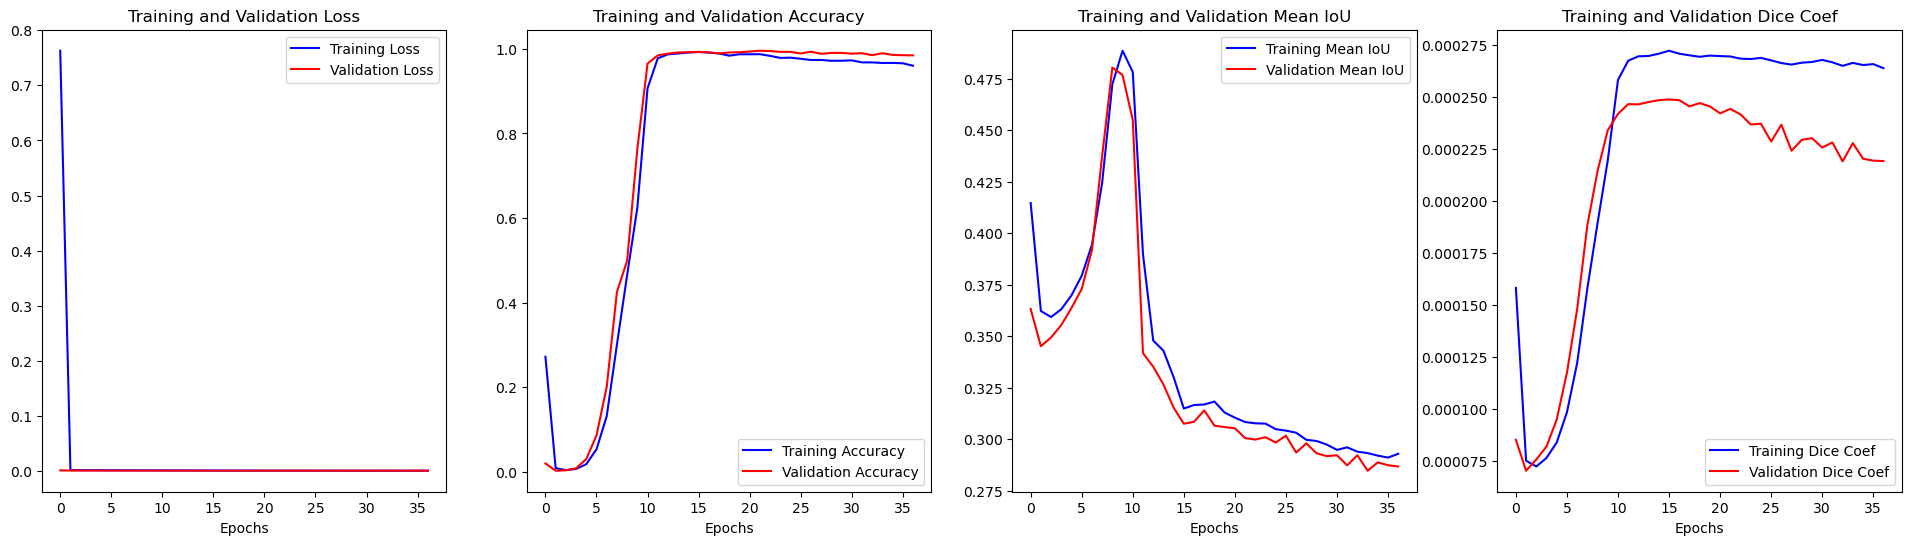

In [190]:
# Extract data from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_mean_io_u = history.history['mean_io_u_21']
val_mean_io_u = history.history['val_mean_io_u_21']
train_dice_coef = history.history['dice_coef']
val_dice_coef = history.history['val_dice_coef']

# Get the number of epochs completed
epochs_completed = len(train_loss)
epochs = range(epochs_completed)

# Define the metrics to plot
metrics = {
    'Loss': (train_loss, val_loss),
    'Accuracy': (train_accuracy, val_accuracy),
    'Mean IoU': (train_mean_io_u, val_mean_io_u),
    'Dice Coef': (train_dice_coef, val_dice_coef)
}

# Create subplots for the different metrics
f, ax = plt.subplots(1, len(metrics), figsize=(24, 6))

# Plot each metric
for i, (metric_name, (train_metric, val_metric)) in enumerate(metrics.items()):
    ax[i].plot(epochs, train_metric, 'b', label='Training ' + metric_name)
    ax[i].plot(epochs, val_metric, 'r', label='Validation ' + metric_name)
    ax[i].legend()
    ax[i].set_title('Training and Validation ' + metric_name)
    ax[i].set_xlabel('Epochs')

# Show the plots
plt.show()

1/1 [==============================] - 0s 35ms/step


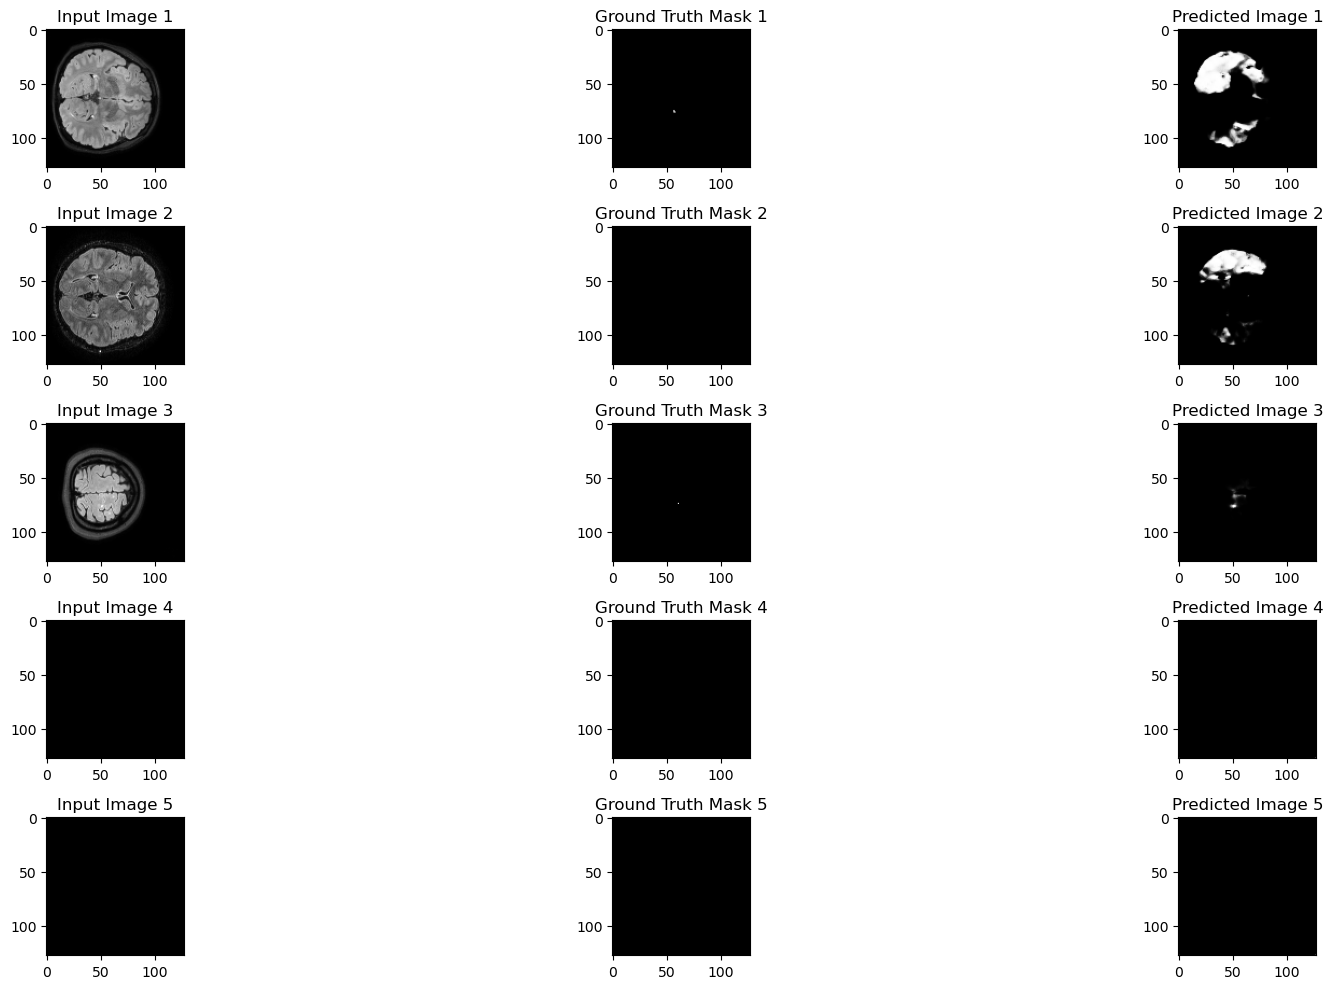

In [185]:
plt.figure(figsize=(20, 10))

# Loop over each sample in the test dataset
for i in range(5):
    # Generate one batch of data
    X, Y_true = test_generator.__getitem__(i)
    
    # Predict the mask for the input image
    Y_pred = ensemble_model.predict(X)
    
    # Display input image
    plt.subplot(5, 3, i * 3 + 1)
    plt.title('Input Image {}'.format(i+1))
    plt.imshow(np.squeeze(X[0, :, :, 0]), cmap='gray')  

    # Display ground truth mask
    plt.subplot(5, 3, i * 3 + 2)
    plt.title('Ground Truth Mask {}'.format(i+1))
    plt.imshow(np.squeeze(Y_true[0, :, :, 0]), cmap='gray')  

    # Display predicted lesion
    plt.subplot(5, 3, i * 3 + 3)
    plt.title('Predicted Image {}'.format(i+1))
    plt.imshow(np.squeeze(Y_pred[0, :, :, 1]), cmap='gray') 

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 40ms/step


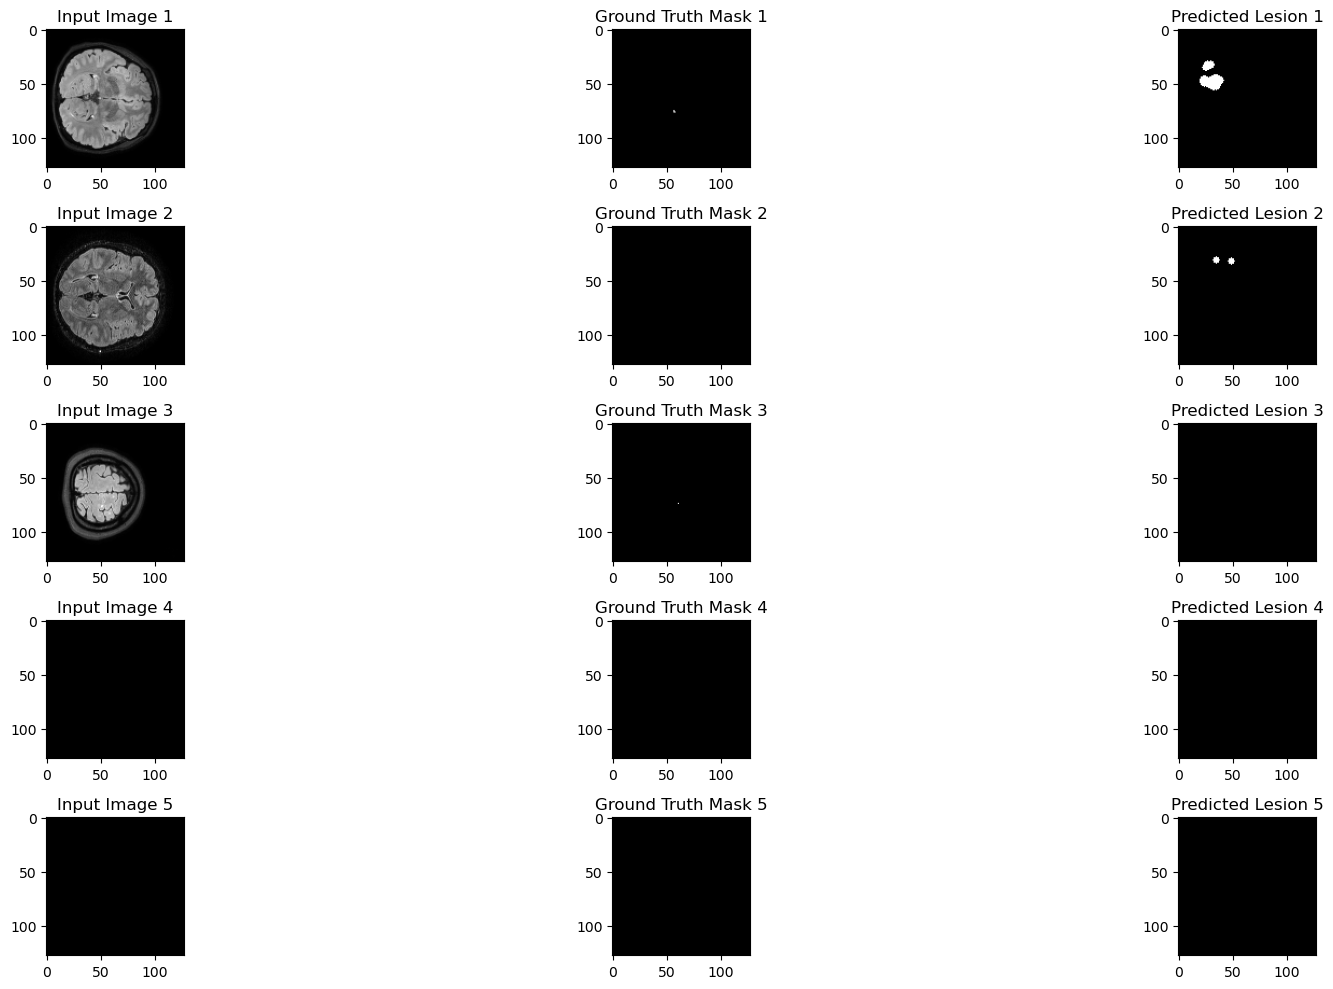

In [205]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology

plt.figure(figsize=(20, 10))

# Loop over each sample in the test dataset
for i in range(5):
    # Generate one batch of data
    X, Y_true = test_generator.__getitem__(i)
    
    # Predict the mask for the input image
    Y_pred = ensemble_model.predict(X)
    
    # Threshold the predicted mask to isolate lesions
    threshold = 0.5
    predicted_lesion_mask = np.squeeze(Y_pred[0, :, :, 1]) > threshold
    
    # Apply morphological operations to refine the predicted mask
    predicted_lesion_mask = morphology.binary_closing(predicted_lesion_mask, morphology.disk(3))
    predicted_lesion_mask = morphology.binary_opening(predicted_lesion_mask, morphology.disk(3))
    
    # Display input image
    plt.subplot(5, 3, i * 3 + 1)
    plt.title('Input Image {}'.format(i+1))
    plt.imshow(np.squeeze(X[0, :, :, 0]), cmap='gray')  

    # Display ground truth mask
    plt.subplot(5, 3, i * 3 + 2)
    plt.title('Ground Truth Mask {}'.format(i+1))
    plt.imshow(np.squeeze(Y_true[0, :, :, 0]), cmap='gray')  

    # Display predicted lesion after morphological operations
    plt.subplot(5, 3, i * 3 + 3)
    plt.title('Predicted Lesion {}'.format(i+1))
    plt.imshow(predicted_lesion_mask, cmap='gray') 

# Adjust layout
plt.tight_layout()
plt.show()